# Transcription Factor Project - QC Testing
**Robin Anwyl, UCSD Subramaniam Lab**

**Goal:** Analyze the hiPSC Perturb-seq dataset from the Mali lab (Nourreddine et al 2023 preprint) to investigate the effects of transcription factor knockouts (TF KDs)

**Guiding Questions:** What do TF KD effects reveal about:
* … the transcription regulatory network of hiPSCs, and TF crosstalk?
* … cell lineage?
* … how TFs influence chromatin remodeling?

# Import statements

Using psp_env virtual environment

In [92]:
import sys
import os
psp_root = "/home/ranwyl/KOLF2.1J_Perturbation_Cell_Atlas/"
if psp_root not in sys.path:
    sys.path.insert(0, psp_root)

import psp
import gc
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'

# Fall 2025 Week 4

## Testing no normalization vs. median normalization before Isolation Forest

Compare dataset with no normalization before `scrub_ntc_cells()` to dataset with normalization before `scrub_ntc_cells()`

In [2]:
adata_no_norm_filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_NTC_Filtered.h5ad"
adata_no_norm = psp.utils.read_anndata(adata_no_norm_filepath)
adata_no_norm

AnnData object with n_obs × n_vars = 411560 × 20043
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'batch', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'counts'

In [3]:
adata_no_norm.obs.perturbed.value_counts()

perturbed
True     397862
False     13698
Name: count, dtype: int64

In [4]:
adata_norm_filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_IFnorm_NTC_Filtered.h5ad"
adata_norm = psp.utils.read_anndata(adata_norm_filepath)
adata_norm

AnnData object with n_obs × n_vars = 411536 × 20043
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'batch', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'counts'

In [5]:
adata_norm.obs.perturbed.value_counts()

perturbed
True     397862
False     13674
Name: count, dtype: int64

In [6]:
adata_norm_ntc_cells = adata_norm[adata_norm.obs.gene_target == "NTC"].obs.index.tolist()
print(adata_norm_ntc_cells[:3])
print(len(adata_norm_ntc_cells))
adata_norm_ntc_cells = set(adata_norm_ntc_cells)

['AAACGAACAAAGCGTG-1', 'AAAGAACAGAGGTGCT-1', 'AAAGAACCAAAGGCAC-1']
13674


In [7]:
adata_no_norm_ntc_cells = adata_no_norm[adata_no_norm.obs.gene_target == "NTC"].obs.index.tolist()
print(adata_no_norm_ntc_cells[:3])
print(len(adata_no_norm_ntc_cells))
adata_no_norm_ntc_cells = set(adata_no_norm_ntc_cells)

['AAACGCTTCTCTTGCG-1', 'AAAGAACAGAGGTGCT-1', 'AACAAAGCAATCAAGA-1']
13698


In [8]:
print(len(adata_norm_ntc_cells - adata_no_norm_ntc_cells))
print(len(adata_no_norm_ntc_cells - adata_norm_ntc_cells))
print(len(adata_norm_ntc_cells & adata_no_norm_ntc_cells))

3803
3827
9871


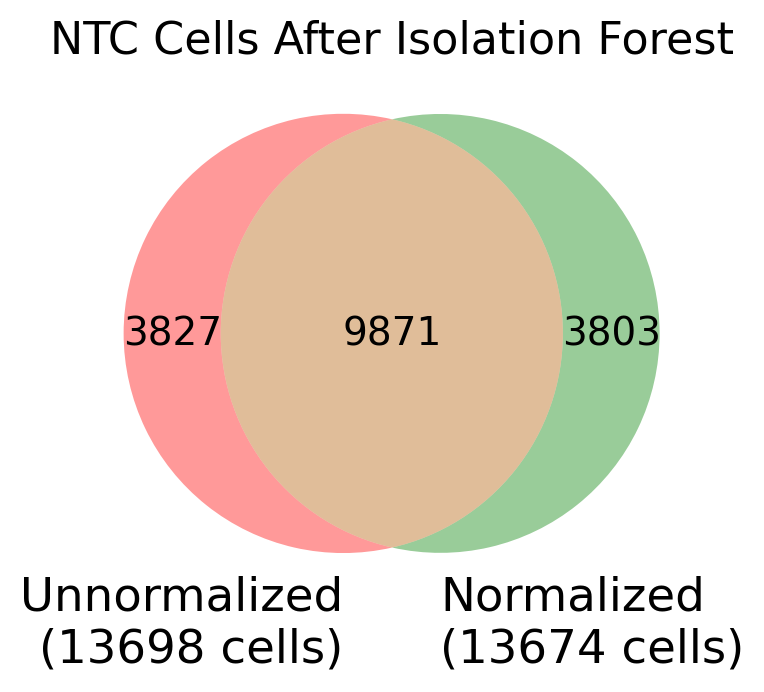

In [11]:
from matplotlib_venn import venn2

def plot_venn2(set1, set2, label1, label2, title=None, color1="red", color2="green"):
    plt.rcParams['font.size'] = 14
    n_items1, n_items2 = len(set1), len(set2)
    n_shared = len([g for g in set2 if g in set1])
    left = n_items1 - n_shared
    right = n_items2 - n_shared
    venn2(subsets = (left, right, n_shared), 
        set_labels = (label1, label2),
        set_colors = (color1, color2),
        alpha=0.4)
    if title:
        plt.title(title, fontsize=16)
    plt.show()

plot_venn2(adata_no_norm_ntc_cells, adata_norm_ntc_cells, 
           "Unnormalized\n(13698 cells)", "Normalized\n(13674 cells)", 
           "NTC Cells After Isolation Forest")

In [2]:
import scanpy as sc

adata_pre_etest_filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_Knockdown_Filtered.h5ad"
adata_unnorm_filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_Knockdown_Energy_Test_Filtered.h5ad"
adata_norm_filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_IFnorm_Knockdown_Energy_Test_Computed.h5ad"

adata_pre_etest = sc.read_h5ad(adata_pre_etest_filepath, backed="r")
adata_unnorm = sc.read_h5ad(adata_unnorm_filepath, backed="r")
adata_norm_unfiltered = sc.read_h5ad(adata_norm_filepath)
adata_norm = adata_norm_unfiltered[
    (adata_norm_unfiltered.obs.perturbed == "False") | 
    (adata_norm_unfiltered.obs.perturbation_significant == True)
].copy()
del adata_norm_unfiltered
gc.collect()

37546

In [11]:
def print_stats(adata):
    print(f"# perturbed cells: {adata[adata.obs.perturbed == 'True'].shape[0]}")
    print(f"# gene targets: {len(adata.obs.gene_target.unique().tolist()) - 1}")
    print(f"# gRNA: {len(adata[adata.obs.perturbed == 'True'].obs.gRNA.unique().tolist())}")

In [12]:
print_stats(adata_pre_etest)

# perturbed cells: 275793
# gene targets: 1368
# gRNA: 3340


In [13]:
print_stats(adata_unnorm)

# perturbed cells: 204601
# gene targets: 1218
# gRNA: 2332


In [14]:
print_stats(adata_norm)

# perturbed cells: 14659
# gene targets: 144
# gRNA: 179


## Testing no normalization vs. CPM normalization before Isolation Forest

Compare dataset with no normalization before `scrub_ntc_cells()` to dataset with normalization before `scrub_ntc_cells()`

In [2]:
adata_no_norm_filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_NTC_Filtered.h5ad"
adata_no_norm = psp.utils.read_anndata(adata_no_norm_filepath)
adata_no_norm

AnnData object with n_obs × n_vars = 411560 × 20043
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'batch', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'counts'

In [3]:
adata_no_norm.obs.perturbed.value_counts()

perturbed
True     397862
False     13698
Name: count, dtype: int64

In [4]:
adata_median_filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_IFnorm_NTC_Filtered.h5ad"
adata_median = psp.utils.read_anndata(adata_median_filepath)
adata_median

AnnData object with n_obs × n_vars = 411536 × 20043
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'batch', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'counts'

In [5]:
adata_cpm_filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_NTC_Filtered.h5ad"
adata_cpm = psp.utils.read_anndata(adata_cpm_filepath)
adata_cpm

AnnData object with n_obs × n_vars = 411536 × 20043
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'batch', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'counts'

In [9]:
adata_cpm.obs.perturbed.value_counts()

perturbed
True     397862
False     13674
Name: count, dtype: int64

In [6]:
adata_no_norm_ntc_cells = \
    set(adata_no_norm[adata_no_norm.obs.gene_target == "NTC"].obs.index.tolist())
adata_cpm_ntc_cells = \
    set(adata_cpm[adata_cpm.obs.gene_target == "NTC"].obs.index.tolist())
adata_median_ntc_cells = \
    set(adata_median[adata_median.obs.gene_target == "NTC"].obs.index.tolist())

In [7]:
print(len(adata_no_norm_ntc_cells - adata_cpm_ntc_cells))
print(len(adata_cpm_ntc_cells - adata_no_norm_ntc_cells))
print(len(adata_cpm_ntc_cells & adata_no_norm_ntc_cells))

1642
1618
12056


In [8]:
print(len(adata_median_ntc_cells - adata_cpm_ntc_cells))
print(len(adata_cpm_ntc_cells - adata_median_ntc_cells))
print(len(adata_cpm_ntc_cells & adata_median_ntc_cells))

2969
2969
10705


In [ ]:
from matplotlib_venn import venn2

def plot_venn2(set1, set2, label1, label2, title=None, color1="red", color2="green"):
    plt.rcParams['font.size'] = 14
    venn2((set1, set2), 
        set_labels = (label1, label2),
        set_colors = (color1, color2),
        alpha=0.4)
    if title:
        plt.title(title, fontsize=16)
    plt.show()

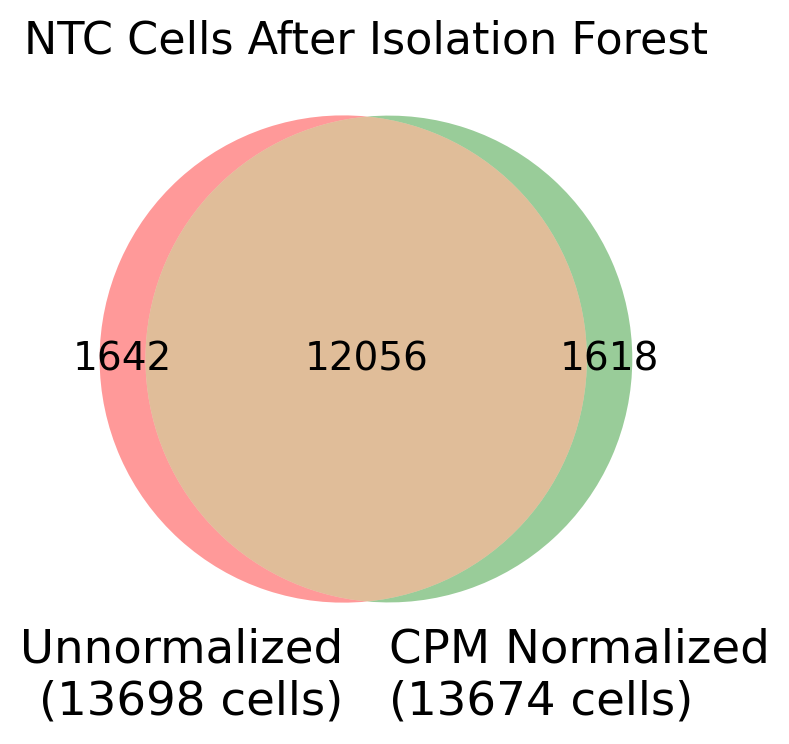

In [14]:
plot_venn2(adata_no_norm_ntc_cells, adata_cpm_ntc_cells, 
           "Unnormalized\n(13698 cells)", "CPM Normalized\n(13674 cells)", 
           "NTC Cells After Isolation Forest")

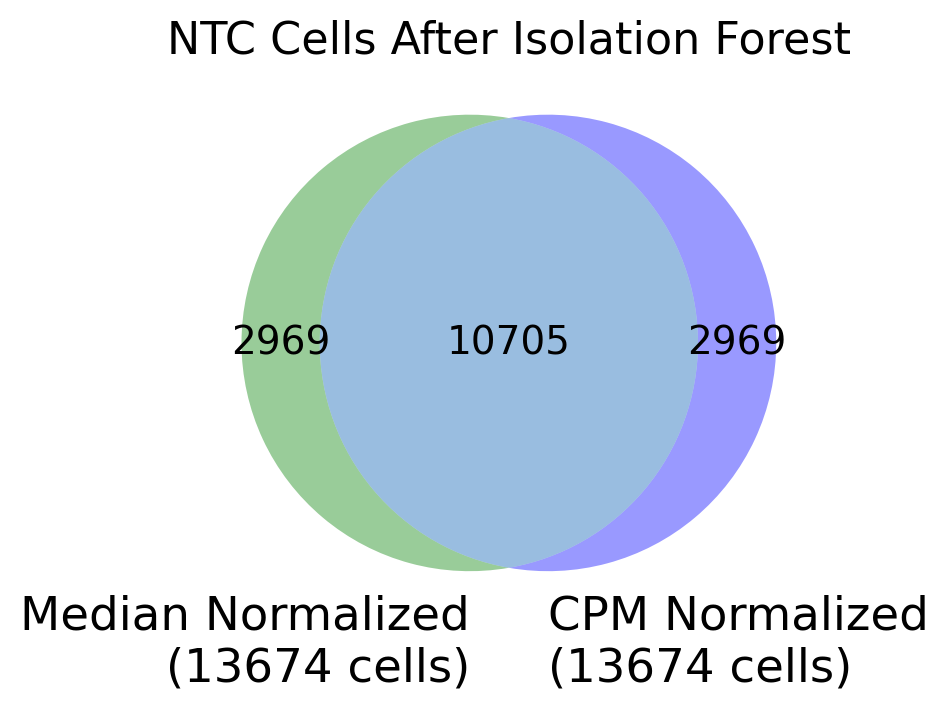

In [25]:
plot_venn2(adata_median_ntc_cells, adata_cpm_ntc_cells, 
           "Median Normalized\n(13674 cells)", "CPM Normalized\n(13674 cells)", 
           color1="green", color2="blue",
           title="NTC Cells After Isolation Forest")

In [21]:
from matplotlib_venn import venn3

def plot_venn3(set1, set2, set3, label1, label2, label3,
               title=None, color1="red", color2="green", color3="blue"):
    plt.rcParams['font.size'] = 12
    venn3((set1, set2, set3), 
        set_labels = (label1, label2, label3),
        set_colors = (color1, color2, color3),
        alpha=0.4)
    if title:
        plt.title(title, fontsize=16)
    plt.show()

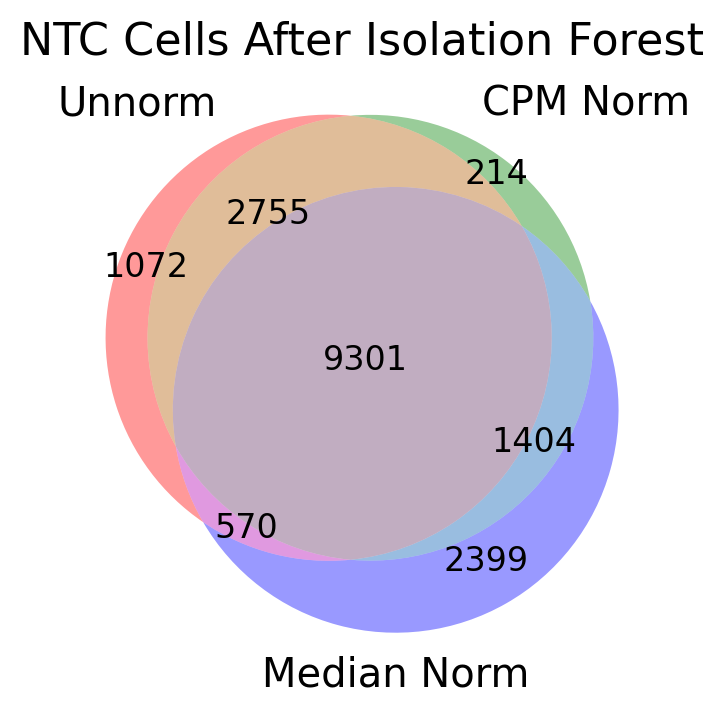

In [23]:
plot_venn3(adata_no_norm_ntc_cells, adata_cpm_ntc_cells, adata_median_ntc_cells,
           "Unnorm", "CPM Norm","Median Norm", "NTC Cells After Isolation Forest")

In [5]:
import scanpy as sc

adata_pre_etest_filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_Knockdown_Filtered.h5ad"
adata_unnorm_filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_Knockdown_Energy_Test_Filtered.h5ad"
adata_norm_filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_Knockdown_Energy_Test_Filtered.h5ad"

adata_pre_etest = sc.read_h5ad(adata_pre_etest_filepath, backed="r")
adata_unnorm = sc.read_h5ad(adata_unnorm_filepath, backed="r")
adata_norm = sc.read_h5ad(adata_norm_filepath, backed="r")

In [6]:
def print_stats(adata):
    print(f"# perturbed cells: {adata[adata.obs.perturbed == 'True'].shape[0]}")
    print(f"# gene targets: {len(adata.obs.gene_target.unique().tolist()) - 1}")
    print(f"# gRNA: {len(adata[adata.obs.perturbed == 'True'].obs.gRNA.unique().tolist())}")

In [7]:
print_stats(adata_pre_etest)

# perturbed cells: 275793
# gene targets: 1368
# gRNA: 3340


In [8]:
print_stats(adata_unnorm)

# perturbed cells: 204601
# gene targets: 1218
# gRNA: 2332


In [9]:
print_stats(adata_norm)

# perturbed cells: 88249
# gene targets: 726
# gRNA: 986


In [13]:
from matplotlib_venn import venn2

def plot_venn2(set1, set2, label1, label2, title=None, color1="red", color2="green"):
    plt.rcParams['font.size'] = 14
    venn2((set1, set2), 
        set_labels = (label1, label2),
        set_colors = (color1, color2),
        alpha=0.4)
    if title:
        plt.title(title, fontsize=14)
    plt.show()

In [14]:
unnorm_pert_gRNA = set(adata_unnorm[adata_unnorm.obs.perturbed == "True"].obs.gRNA.unique().tolist())
norm_pert_gRNA = set(adata_norm[adata_norm.obs.perturbed == "True"].obs.gRNA.unique().tolist())
print(f"# perturbing gRNA (unnormalized): {len(unnorm_pert_gRNA)}")
print(f"# perturbing gRNA (CPM normalized): {len(norm_pert_gRNA)}")

# perturbing gRNA (unnormalized): 2332
# perturbing gRNA (CPM normalized): 986


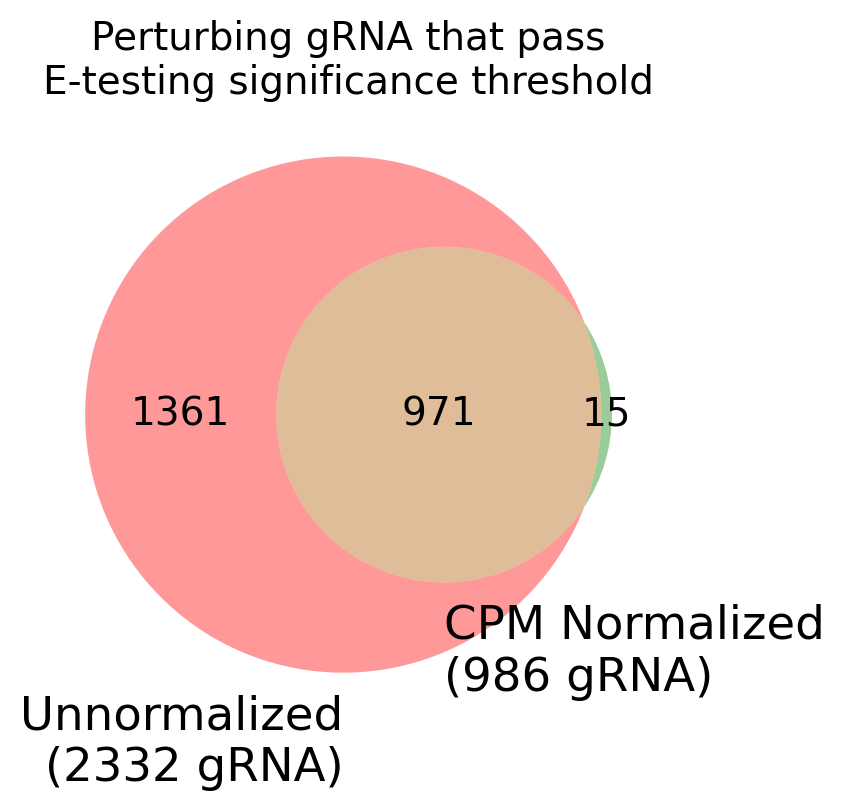

In [15]:
plot_venn2(unnorm_pert_gRNA, norm_pert_gRNA,
           "Unnormalized\n(2332 gRNA)",
           "CPM Normalized\n(986 gRNA)",
           title="Perturbing gRNA that pass\nE-testing significance threshold")

## DE genome coverage testing

In [2]:
import numpy as np
import anndata as ad
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams.update({'font.size': 12})

def compute_gene_coverage_for_gRNA_pseudoreps(adata: ad.AnnData, gRNA: str, 
                                            rng: np.random.Generator,
                                            include_total: bool=True) -> dict:
    """
    Generate differential expression analysis pseudoreplicates for the given gRNA
    and compute genome coverage (number of genes expressed in rep divided by
    number of genes in dataset) and gRNA gene coverage (number of genes expressed
    in rep divided by number of genes expressed in all cells receiving that gRNA).
    """
    data_matrix = adata.X
    total_n_genes = adata.shape[1]
    genome_coverage = list() # n genes expressed in rep/n genes in adata
    gRNA_gene_coverage = list() # n genes expressed in rep/n genes expressed by gRNA cells
    # Create gRNA pseudoreplicates
    gRNA_indices = np.where(adata.obs['gRNA'] == gRNA)[0]
    n_cells = len(gRNA_indices)
    n_reps = 2 if n_cells <= 35 else 3
    rep_size = len(gRNA_indices) // n_reps
    sample_size = rep_size * n_reps
    sampled_gRNA_indices = rng.choice(gRNA_indices, sample_size, replace=False)
    # Number of expressed genes for all cells that received this gRNA
    gRNA_profile = data_matrix[sampled_gRNA_indices].sum(axis=0)
    gRNA_n_expr_genes = np.count_nonzero(gRNA_profile)
    # Compute genome coverage for each rep
    for rep in range(n_reps):
        # Number of expressed genes in rep
        start, stop = rep*rep_size, (rep+1)*rep_size
        rep_indices = sampled_gRNA_indices[start:stop]
        rep_profile = data_matrix[rep_indices].sum(axis=0)
        rep_n_expr_genes = np.count_nonzero(rep_profile)
        # Genome coverage
        rep_genome_coverage = np.round(rep_n_expr_genes / total_n_genes, 2)
        genome_coverage.append(rep_genome_coverage)
        # gRNA gene coverage
        rep_gRNA_gene_coverage = np.round(rep_n_expr_genes / gRNA_n_expr_genes, 2)
        gRNA_gene_coverage.append(rep_gRNA_gene_coverage)
    # If no 3rd rep, add NaN value
    if len(genome_coverage) == 2:
        genome_coverage.append(np.nan)
    if len(gRNA_gene_coverage) == 2:
        gRNA_gene_coverage.append(np.nan)
    # Add total
    if include_total == True:
        total_genome_coverage = np.round(gRNA_n_expr_genes / total_n_genes, 2)
        genome_coverage.append(total_genome_coverage)
    # Return results
    results_dict = {"genome_coverage": genome_coverage,
                    "gRNA_gene_coverage": gRNA_gene_coverage}
    return results_dict

def build_DE_gRNA_rep_genome_coverage_df(adata: ad.AnnData, n_cells_per_gRNA: list = [], 
                                    n_gRNA_per_size: int = 0, gRNA_list: list = [],
                                    random_state: int=42, include_total: bool=True,
                                    n_reps: int=3):
    """
    For each of the given numbers of cells per gRNA, sample a given number of gRNA,
    generate differential expression analysis pseudoreplicates for each gRNA,
    and compute genome coverage (number of genes expressed in rep divided by
    number of genes in dataset) and gRNA gene coverage (number of genes expressed
    in rep divided by number of genes expressed in all cells receiving that gRNA).
    """
    # Check that necessary inputs are provided
    if n_cells_per_gRNA != [] and n_gRNA_per_size == 0:
        print("Error: must provide number of gRNA to sample per size (cell number)")
    if n_cells_per_gRNA == [] and n_gRNA_per_size != 0:
        print("Error: must provide list of gRNA cell numbers")
    if n_cells_per_gRNA == [] and gRNA_list == []:
        print("Error: must provide list of gRNA or gRNA cell numbers")

    # Subset only KD cells and reset adata.X to counts
    adata = adata[adata.obs.perturbed == "True"].copy()
    adata.X = adata.layers["counts"].copy()

    # Build DF of number of cells per gRNA
    cells_per_gRNA = adata.obs.gRNA.value_counts()
    cells_per_gRNA = cells_per_gRNA.rename_axis("gRNA").reset_index(name="n_cells")

    # Generate RNG objects
    rng = np.random.default_rng(random_state)
    rngs = rng.spawn(2)
    gRNA_rng, reps_rng = rngs[0], rngs[1]
    
    # Initialize dicts for genome coverage and gRNA gene coverage
    genome_coverage_dict = dict()
    gRNA_gene_coverage_dict = dict()

    # If a gRNA list is not provided, randomly sample gRNA
    if gRNA_list == []:
        # Loop through desired sizes of cells, e.g. [25, 30)
        for i in range(len(n_cells_per_gRNA)-1):
            # Filter to only gRNA with desired number of cells
            min_n_cells, max_n_cells = n_cells_per_gRNA[i], n_cells_per_gRNA[i+1]
            print(f"Sampling gRNA with {min_n_cells}-{max_n_cells-1} cells")
            filt_cells_per_gRNA = \
                cells_per_gRNA[(cells_per_gRNA["n_cells"] >= min_n_cells) & 
                (cells_per_gRNA["n_cells"] < max_n_cells)].copy()
            # If DF is empty, skip this cell number
            if filt_cells_per_gRNA.empty:
                continue
            # If number of gRNA > desired number, sample randomly
            if filt_cells_per_gRNA.shape[0] > n_gRNA_per_size:
                all_gRNA_indices = filt_cells_per_gRNA.index.tolist()
                chosen_gRNA_indices = gRNA_rng.choice(all_gRNA_indices, n_gRNA_per_size,
                                        replace=False)
                filt_cells_per_gRNA = \
                    filt_cells_per_gRNA[filt_cells_per_gRNA.index.isin(chosen_gRNA_indices)].copy()
            # Build gRNA list
            filt_cells_per_gRNA.sort_values(by="n_cells", inplace=True)
            gRNA_list += filt_cells_per_gRNA["gRNA"].tolist()
    else: # Sort gRNA list by number of cells per gRNA
        filt_cells_per_gRNA = cells_per_gRNA[cells_per_gRNA["gRNA"].isin(gRNA_list)].copy()
        filt_cells_per_gRNA.sort_values(by="n_cells", inplace=True)
        gRNA_list = filt_cells_per_gRNA["gRNA"].tolist()

    # For all gRNA, generate pseudoreps and calculate genome + gRNA gene coverage
    for i in tqdm(range(len(gRNA_list)), desc="Computing coverage for gRNA"):
        gRNA = gRNA_list[i]
        # Get number of cells for gRNA
        gRNA_idx = cells_per_gRNA[cells_per_gRNA["gRNA"] == gRNA].index[0]
        gRNA_n_cells = cells_per_gRNA.at[gRNA_idx, "n_cells"]
        gRNA_entry = f"{gRNA} ({gRNA_n_cells} cells)"
        # Compute genome and gRNA gene coverage for pseudoreps
        gRNA_coverage = \
            compute_gene_coverage_for_gRNA_pseudoreps(adata, gRNA, reps_rng, include_total)
        genome_entry = {f"rep{i+1}": gRNA_coverage["genome_coverage"][i] for i in range(n_reps)}
        if include_total == True:
            genome_entry["total"] = gRNA_coverage["genome_coverage"][-1]
        gene_entry = {f"rep{i+1}": gRNA_coverage["gRNA_gene_coverage"][i] for i in range(n_reps)}
        genome_coverage_dict[gRNA_entry] = genome_entry
        gRNA_gene_coverage_dict[gRNA_entry] = gene_entry
    
    # Build DFs
    genome_coverage_df = pd.DataFrame.from_dict(genome_coverage_dict, orient="index")
    gRNA_gene_coverage_df = pd.DataFrame.from_dict(gRNA_gene_coverage_dict, orient="index")
    return genome_coverage_df, gRNA_gene_coverage_df

def compute_gene_coverage_for_kd_pseudoreps(adata: ad.AnnData, kd: str, 
                                            rng: np.random.Generator,
                                            include_total: bool=True) -> dict:
    """
    Generate differential expression analysis pseudoreplicates for the given
    gene target KD and compute genome coverage (number of genes expressed in rep 
    divided by number of genes in dataset) and gene target gene coverage 
    (number of genes expressed in rep divided by number of genes expressed in 
    all cells corresponding to that KD).
    """
    data_matrix = adata.X
    total_n_genes = adata.shape[1]
    genome_coverage = list() # n genes expressed in rep/n genes in adata
    kd_gene_coverage = list() # n genes expressed in rep/n genes expressed by KD cells
    # Create KD pseudoreplicates
    kd_indices = np.where(adata.obs['gene_target'] == kd)[0]
    n_cells = len(kd_indices)
    n_reps = 2 if n_cells <= 35 else 3
    rep_size = len(kd_indices) // n_reps
    sample_size = rep_size * n_reps
    sampled_kd_indices = rng.choice(kd_indices, sample_size, replace=False)
    # Number of expressed genes for all cells with this gene target
    kd_profile = data_matrix[sampled_kd_indices].sum(axis=0)
    kd_n_expr_genes = np.count_nonzero(kd_profile)
    # Compute genome coverage for each rep
    for rep in range(n_reps):
        # Number of expressed genes in rep
        start, stop = rep*rep_size, (rep+1)*rep_size
        rep_indices = sampled_kd_indices[start:stop]
        rep_profile = data_matrix[rep_indices].sum(axis=0)
        rep_n_expr_genes = np.count_nonzero(rep_profile)
        # Genome coverage
        rep_genome_coverage = np.round(rep_n_expr_genes / total_n_genes, 2)
        genome_coverage.append(rep_genome_coverage)
        # KD gene coverage
        rep_kd_gene_coverage = np.round(rep_n_expr_genes / kd_n_expr_genes, 2)
        kd_gene_coverage.append(rep_kd_gene_coverage)
    # If no 3rd rep, add NaN value
    if len(genome_coverage) == 2:
        genome_coverage.append(np.nan)
    if len(kd_gene_coverage) == 2:
        kd_gene_coverage.append(np.nan)
    # Add total
    if include_total == True:
        total_genome_coverage = np.round(kd_n_expr_genes / total_n_genes, 2)
        genome_coverage.append(total_genome_coverage)
    # Return results
    results_dict = {"genome_coverage": genome_coverage,
                    "KD_gene_coverage": kd_gene_coverage}
    return results_dict

def build_DE_KD_rep_genome_coverage_df(adata: ad.AnnData, kd_list: list,
                                    random_state: int=42, n_reps: int=3,
                                    include_total: bool=True):
    """
    Generate differential expression analysis pseudoreplicates for each KD, 
    and compute genome coverage (number of genes expressed in rep divided by
    number of genes in dataset) and KD gene coverage (number of genes expressed
    in rep divided by number of genes expressed in all cells of that KD).
    """
    # Subset only KD cells and reset adata.X to counts
    adata = adata[adata.obs.perturbed == "True"].copy()
    adata.X = adata.layers["counts"].copy()

    # Build cells per gene target DF and sort by number of cells
    cells_per_kd = adata.obs.gene_target.value_counts()
    cells_per_kd = cells_per_kd.rename_axis("gene_target").reset_index(name="n_cells")
    cells_per_kd = cells_per_kd[cells_per_kd["gene_target"].isin(kd_list)]
    cells_per_kd.sort_values(by="n_cells", inplace=True)
    kd_list = cells_per_kd["gene_target"].tolist()

    # Generate RNG object
    rng = np.random.default_rng(random_state)
    
    # Compute genome coverage and KD gene coverage
    genome_coverage_dict = dict()
    kd_gene_coverage_dict = dict()
    for i in tqdm(range(len(kd_list)), desc="Computing coverage for KD gene target"):
        kd = kd_list[i]
        # Get number of cells for KD
        kd_cell_num = adata[adata.obs.gene_target == kd].shape[0]
        kd_entry = f"{kd} ({kd_cell_num} cells)"
        # Compute genome and gRNA gene coverage for pseudoreps
        kd_coverage = compute_gene_coverage_for_kd_pseudoreps(adata, kd, rng, include_total)
        genome_entry = {f"rep{i+1}": kd_coverage["genome_coverage"][i] for i in range(n_reps)}
        if include_total == True:
            genome_entry["total"] = kd_coverage["genome_coverage"][-1]
        gene_entry = {f"rep{i+1}": kd_coverage["KD_gene_coverage"][i] for i in range(n_reps)}
        genome_coverage_dict[kd_entry] = genome_entry
        kd_gene_coverage_dict[kd_entry] = gene_entry
    
    # Build DFs
    genome_coverage_df = pd.DataFrame.from_dict(genome_coverage_dict, orient="index")
    kd_gene_coverage_df = pd.DataFrame.from_dict(kd_gene_coverage_dict, orient="index")
    return genome_coverage_df, kd_gene_coverage_df

def calculate_kd_genome_coverage(adata: ad.AnnData, kd_list: list):
    adata = adata.copy()
    adata.X = adata.layers["counts"].copy()
    data_matrix = adata.X
    total_n_genes = adata.shape[1]
    kd_genome_coverage_dict = dict()
    for kd in kd_list:
        # Number of expressed genes for all cells with this gene target
        kd_indices = np.where(adata.obs['gene_target'] == kd)[0]
        kd_profile = data_matrix[kd_indices].sum(axis=0)
        kd_n_expr_genes = np.count_nonzero(kd_profile)
        kd_genome_coverage = np.round(kd_n_expr_genes/total_n_genes, 2)
        kd_genome_coverage_dict[kd] = kd_genome_coverage
    return kd_genome_coverage_dict

def plot_gene_coverage_heatmap(gene_coverage_df: pd.DataFrame, title: str,
                               cmap: str="viridis", annot: bool=True,
                               figsize: tuple=(3,8)):
    plt.figure(figsize=figsize)
    nan_mask = gene_coverage_df.isna()
    ax = sns.heatmap(gene_coverage_df, cmap=cmap, annot=annot, annot_kws={"size": 8},
        mask=nan_mask, vmin=0, vmax=1, linewidths=0.5, xticklabels=True)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=10)
    plt.grid(False)
    plt.title(title, pad=10, fontsize=12)
    plt.show()

In [3]:
import anndata as ad

adata_filepath = \
    "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_Knockdown_Energy_Test_Filtered.h5ad"
test_adata = ad.read_h5ad(adata_filepath)
test_adata

AnnData object with n_obs × n_vars = 101923 × 20043
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [4]:
test_adata.n_vars

20043

Sample 5 gRNA of each size 25-50 cells in multiples of 5

Does each gRNA pseudorep cover 75% of dataset genes?

In [5]:
test_res_gRNA = build_DE_gRNA_rep_genome_coverage_df(test_adata, 
    n_cells_per_gRNA = [25, 30, 35, 40, 45, 50], n_gRNA_per_size=5, random_state=12345)
test_genome_coverage_df, test_gRNA_coverage_df = test_res_gRNA

Sampling gRNA with 25-29 cells
Sampling gRNA with 30-34 cells
Sampling gRNA with 35-39 cells
Sampling gRNA with 40-44 cells
Sampling gRNA with 45-49 cells


Computing coverage for gRNA: 100%|██████████| 25/25 [00:42<00:00,  1.70s/it]


In [ ]:
plot_gene_coverage_heatmap(test_genome_coverage_df, figsize=(4,8),
    title="gRNA replicates - genome coverage")

What about the same for each knockdown/gene target, which can include up to 3 unique gRNAs?

In [7]:
test_gene_targets = [kd.split("_")[0] for kd in test_genome_coverage_df.index.tolist()]
print(test_gene_targets)

['ZNF408', 'ZNF335', 'POU5F1', 'GATA6', 'SETDB1', 'RLF', 'TGIF1', 'ZNF234', 'DR1', 'ZNF71', 'FOXI3', 'POGK', 'NANOG', 'ZBTB11', 'XPA', 'SAFB', 'GLI2', 'NFIA', 'EBF2', 'POU5F1B', 'ZNF397', 'NFYB', 'ZNF256', 'MTF1', 'ZNF804B']


In [8]:
test_res_kd = build_DE_KD_rep_genome_coverage_df(test_adata, test_gene_targets)
test_kd_genome_coverage_df, test_kd_coverage_df = test_res_kd

Computing coverage for KD gene target: 100%|██████████| 25/25 [00:46<00:00,  1.87s/it]


Does each KD pseudorep achieve 75% genome coverage?

In [ ]:
plot_gene_coverage_heatmap(test_kd_genome_coverage_df,
    "KD replicates - genome coverage", figsize=(4,8), cmap="plasma")

What about KDs with a low cell number?

In [10]:
low_kds = test_adata.obs.gene_target.value_counts().tail(25).index.tolist()
print(low_kds)

['POU5F1B', 'CREB1', 'THAP9', 'TSC22D1', 'TOPORS', 'NFIA', 'KLF9', 'SOX2', 'SOX6', 'LIN28B', 'GLI2', 'E2F1', 'ELF5', 'ZNF511', 'SAFB', 'ZNF148', 'ZBTB11', 'ZNF81', 'NANOGP8', 'FOXI3', 'NFE4', 'GTF3A', 'ZIC2', 'ZNF408', 'ZNF335']


In [11]:
test_res_kd_low = build_DE_KD_rep_genome_coverage_df(test_adata, low_kds)
test_kd_low_genome_coverage_df, test_kd_low_coverage_df = test_res_kd_low

Computing coverage for KD gene target: 100%|██████████| 25/25 [00:45<00:00,  1.80s/it]


In [ ]:
display(test_kd_low_genome_coverage_df)

What about KDs with a high cell number?

In [13]:
test_adata.obs.gRNA.value_counts().head(10)

gRNA
HNF1A_1       279
BHLHE40_1     279
ARHGAP35_3    252
ZFP41_3       241
HNF4A_2       239
ZNF658_2      238
ZNF354A_1     226
VDR_2         226
ADNP2_1       215
ZFP37_2       214
Name: count, dtype: int64

In [14]:
high_cell_number_gRNA = test_adata.obs.gRNA.value_counts().head(10).index.tolist()
print(high_cell_number_gRNA)

['HNF1A_1', 'BHLHE40_1', 'ARHGAP35_3', 'ZFP41_3', 'HNF4A_2', 'ZNF658_2', 'ZNF354A_1', 'VDR_2', 'ADNP2_1', 'ZFP37_2']


In [15]:
high_cell_num_gRNA_res = \
    build_DE_gRNA_rep_genome_coverage_df(test_adata, gRNA_list=high_cell_number_gRNA)
test_hi_gRNA_genome_coverage_df, test_hi_gRNA_gene_coverage_df = high_cell_num_gRNA_res

Computing coverage for gRNA: 100%|██████████| 10/10 [00:19<00:00,  1.99s/it]


In [16]:
display(test_hi_gRNA_genome_coverage_df)

,rep1,rep2,rep3,total
ZFP37_2 (214 cells),0.79,0.80,0.80,0.92
ADNP2_1 (215 cells),0.80,0.80,0.79,0.91
ZNF354A_1 (226 cells),0.81,0.80,0.79,0.92
VDR_2 (226 cells),0.80,0.80,0.81,0.92
ZNF658_2 (238 cells),0.80,0.81,0.82,0.92
HNF4A_2 (239 cells),0.81,0.81,0.81,0.92
ZFP41_3 (241 cells),0.82,0.81,0.81,0.92
ARHGAP35_3 (252 cells),0.80,0.81,0.82,0.92
BHLHE40_1 (279 cells),0.83,0.83,0.83,0.94
HNF1A_1 (279 cells),0.83,0.83,0.84,0.94


Dataset with KD cells only

In [17]:
test_adata_kds = test_adata[test_adata.obs.perturbation_significant == True].copy()
test_adata_kds

AnnData object with n_obs × n_vars = 88249 × 20043
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [21]:
print(f"# of KDs: {test_adata_kds.obs.gene_target.nunique()}")
print(f"# of gRNAs: {test_adata_kds.obs.gRNA.nunique()}")

# of KDs: 726
# of gRNAs: 986


### Apply stricter gene filter

In [22]:
import numpy as np
import anndata as ad
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams.update({'font.size': 12})

def compute_gene_coverage_for_gRNA_pseudoreps(adata: ad.AnnData, gRNA: str, 
                                            rng: np.random.Generator,
                                            include_total: bool=True) -> dict:
    """
    Generate differential expression analysis pseudoreplicates for the given gRNA
    and compute genome coverage (number of genes expressed in rep divided by
    number of genes in dataset) and gRNA gene coverage (number of genes expressed
    in rep divided by number of genes expressed in all cells receiving that gRNA).
    """
    data_matrix = adata.X
    total_n_genes = adata.shape[1]
    genome_coverage = list() # n genes expressed in rep/n genes in adata
    gRNA_gene_coverage = list() # n genes expressed in rep/n genes expressed by gRNA cells
    # Create gRNA pseudoreplicates
    gRNA_indices = np.where(adata.obs['gRNA'] == gRNA)[0]
    n_cells = len(gRNA_indices)
    n_reps = 2 if n_cells <= 35 else 3
    rep_size = len(gRNA_indices) // n_reps
    sample_size = rep_size * n_reps
    sampled_gRNA_indices = rng.choice(gRNA_indices, sample_size, replace=False)
    # Number of expressed genes for all cells that received this gRNA
    gRNA_profile = data_matrix[sampled_gRNA_indices].sum(axis=0)
    gRNA_n_expr_genes = np.count_nonzero(gRNA_profile)
    # Compute genome coverage for each rep
    for rep in range(n_reps):
        # Number of expressed genes in rep
        start, stop = rep*rep_size, (rep+1)*rep_size
        rep_indices = sampled_gRNA_indices[start:stop]
        rep_profile = data_matrix[rep_indices].sum(axis=0)
        rep_n_expr_genes = np.count_nonzero(rep_profile)
        # Genome coverage
        rep_genome_coverage = np.round(rep_n_expr_genes / total_n_genes, 2)
        genome_coverage.append(rep_genome_coverage)
        # gRNA gene coverage
        rep_gRNA_gene_coverage = np.round(rep_n_expr_genes / gRNA_n_expr_genes, 2)
        gRNA_gene_coverage.append(rep_gRNA_gene_coverage)
    # If no 3rd rep, add NaN value
    if len(genome_coverage) == 2:
        genome_coverage.append(np.nan)
    if len(gRNA_gene_coverage) == 2:
        gRNA_gene_coverage.append(np.nan)
    # Add total
    if include_total == True:
        total_genome_coverage = np.round(gRNA_n_expr_genes / total_n_genes, 2)
        genome_coverage.append(total_genome_coverage)
    # Return results
    results_dict = {"genome_coverage": genome_coverage,
                    "gRNA_gene_coverage": gRNA_gene_coverage}
    return results_dict

def build_DE_gRNA_rep_genome_coverage_df(adata: ad.AnnData, n_cells_per_gRNA: list = [], 
                                    n_gRNA_per_size: int = 0, gRNA_list: list = [],
                                    random_state: int=42, include_total: bool=True,
                                    n_reps: int=3):
    """
    For each of the given numbers of cells per gRNA, sample a given number of gRNA,
    generate differential expression analysis pseudoreplicates for each gRNA,
    and compute genome coverage (number of genes expressed in rep divided by
    number of genes in dataset) and gRNA gene coverage (number of genes expressed
    in rep divided by number of genes expressed in all cells receiving that gRNA).
    """
    # Check that necessary inputs are provided
    if n_cells_per_gRNA != [] and n_gRNA_per_size == 0:
        print("Error: must provide number of gRNA to sample per size (cell number)")
    if n_cells_per_gRNA == [] and n_gRNA_per_size != 0:
        print("Error: must provide list of gRNA cell numbers")
    if n_cells_per_gRNA == [] and gRNA_list == []:
        print("Error: must provide list of gRNA or gRNA cell numbers")

    # Subset only KD cells and reset adata.X to counts
    adata = adata[adata.obs.perturbed == "True"].copy()
    adata.X = adata.layers["counts"].copy()

    # Build DF of number of cells per gRNA
    cells_per_gRNA = adata.obs.gRNA.value_counts()
    cells_per_gRNA = cells_per_gRNA.rename_axis("gRNA").reset_index(name="n_cells")

    # Generate RNG objects
    rng = np.random.default_rng(random_state)
    rngs = rng.spawn(2)
    gRNA_rng, reps_rng = rngs[0], rngs[1]
    
    # Initialize dicts for genome coverage and gRNA gene coverage
    genome_coverage_dict = dict()
    gRNA_gene_coverage_dict = dict()

    # If a gRNA list is not provided, randomly sample gRNA
    if gRNA_list == []:
        # Loop through desired sizes of cells, e.g. [25, 30)
        for i in range(len(n_cells_per_gRNA)-1):
            # Filter to only gRNA with desired number of cells
            min_n_cells, max_n_cells = n_cells_per_gRNA[i], n_cells_per_gRNA[i+1]
            print(f"Sampling gRNA with {min_n_cells}-{max_n_cells-1} cells")
            filt_cells_per_gRNA = \
                cells_per_gRNA[(cells_per_gRNA["n_cells"] >= min_n_cells) & 
                (cells_per_gRNA["n_cells"] < max_n_cells)].copy()
            # If DF is empty, skip this cell number
            if filt_cells_per_gRNA.empty:
                continue
            # If number of gRNA > desired number, sample randomly
            if filt_cells_per_gRNA.shape[0] > n_gRNA_per_size:
                all_gRNA_indices = filt_cells_per_gRNA.index.tolist()
                chosen_gRNA_indices = gRNA_rng.choice(all_gRNA_indices, n_gRNA_per_size,
                                        replace=False)
                filt_cells_per_gRNA = \
                    filt_cells_per_gRNA[filt_cells_per_gRNA.index.isin(chosen_gRNA_indices)].copy()
            # Build gRNA list
            filt_cells_per_gRNA.sort_values(by="n_cells", inplace=True)
            gRNA_list += filt_cells_per_gRNA["gRNA"].tolist()
    else: # Sort gRNA list by number of cells per gRNA
        filt_cells_per_gRNA = cells_per_gRNA[cells_per_gRNA["gRNA"].isin(gRNA_list)].copy()
        filt_cells_per_gRNA.sort_values(by="n_cells", inplace=True)
        gRNA_list = filt_cells_per_gRNA["gRNA"].tolist()

    # For all gRNA, generate pseudoreps and calculate genome + gRNA gene coverage
    for i in tqdm(range(len(gRNA_list)), desc="Computing coverage for gRNA"):
        gRNA = gRNA_list[i]
        # Get number of cells for gRNA
        gRNA_idx = cells_per_gRNA[cells_per_gRNA["gRNA"] == gRNA].index[0]
        gRNA_n_cells = cells_per_gRNA.at[gRNA_idx, "n_cells"]
        gRNA_entry = f"{gRNA} ({gRNA_n_cells} cells)"
        # Compute genome and gRNA gene coverage for pseudoreps
        gRNA_coverage = \
            compute_gene_coverage_for_gRNA_pseudoreps(adata, gRNA, reps_rng, include_total)
        genome_entry = {f"rep{i+1}": gRNA_coverage["genome_coverage"][i] for i in range(n_reps)}
        if include_total == True:
            genome_entry["total"] = gRNA_coverage["genome_coverage"][-1]
        gene_entry = {f"rep{i+1}": gRNA_coverage["gRNA_gene_coverage"][i] for i in range(n_reps)}
        genome_coverage_dict[gRNA_entry] = genome_entry
        gRNA_gene_coverage_dict[gRNA_entry] = gene_entry
    
    # Build DFs
    genome_coverage_df = pd.DataFrame.from_dict(genome_coverage_dict, orient="index")
    gRNA_gene_coverage_df = pd.DataFrame.from_dict(gRNA_gene_coverage_dict, orient="index")
    return genome_coverage_df, gRNA_gene_coverage_df

def compute_gene_coverage_for_kd_pseudoreps(adata: ad.AnnData, kd: str, 
                                            rng: np.random.Generator,
                                            include_total: bool=True) -> dict:
    """
    Generate differential expression analysis pseudoreplicates for the given
    gene target KD and compute genome coverage (number of genes expressed in rep 
    divided by number of genes in dataset) and gene target gene coverage 
    (number of genes expressed in rep divided by number of genes expressed in 
    all cells corresponding to that KD).
    """
    data_matrix = adata.X
    total_n_genes = adata.shape[1]
    genome_coverage = list() # n genes expressed in rep/n genes in adata
    kd_gene_coverage = list() # n genes expressed in rep/n genes expressed by KD cells
    # Create KD pseudoreplicates
    kd_indices = np.where(adata.obs['gene_target'] == kd)[0]
    n_cells = len(kd_indices)
    n_reps = 2 if n_cells <= 35 else 3
    rep_size = len(kd_indices) // n_reps
    sample_size = rep_size * n_reps
    sampled_kd_indices = rng.choice(kd_indices, sample_size, replace=False)
    # Number of expressed genes for all cells with this gene target
    kd_profile = data_matrix[sampled_kd_indices].sum(axis=0)
    kd_n_expr_genes = np.count_nonzero(kd_profile)
    # Compute genome coverage for each rep
    for rep in range(n_reps):
        # Number of expressed genes in rep
        start, stop = rep*rep_size, (rep+1)*rep_size
        rep_indices = sampled_kd_indices[start:stop]
        rep_profile = data_matrix[rep_indices].sum(axis=0)
        rep_n_expr_genes = np.count_nonzero(rep_profile)
        # Genome coverage
        rep_genome_coverage = np.round(rep_n_expr_genes / total_n_genes, 2)
        genome_coverage.append(rep_genome_coverage)
        # KD gene coverage
        rep_kd_gene_coverage = np.round(rep_n_expr_genes / kd_n_expr_genes, 2)
        kd_gene_coverage.append(rep_kd_gene_coverage)
    # If no 3rd rep, add NaN value
    if len(genome_coverage) == 2:
        genome_coverage.append(np.nan)
    if len(kd_gene_coverage) == 2:
        kd_gene_coverage.append(np.nan)
    # Add total
    if include_total == True:
        total_genome_coverage = np.round(kd_n_expr_genes / total_n_genes, 2)
        genome_coverage.append(total_genome_coverage)
    # Return results
    results_dict = {"genome_coverage": genome_coverage,
                    "KD_gene_coverage": kd_gene_coverage}
    return results_dict

def build_DE_KD_rep_genome_coverage_df(adata: ad.AnnData, kd_list: list,
                                    random_state: int=42, n_reps: int=3,
                                    include_total: bool=True):
    """
    Generate differential expression analysis pseudoreplicates for each KD, 
    and compute genome coverage (number of genes expressed in rep divided by
    number of genes in dataset) and KD gene coverage (number of genes expressed
    in rep divided by number of genes expressed in all cells of that KD).
    """
    # Subset only KD cells and reset adata.X to counts
    adata = adata[adata.obs.perturbed == "True"].copy()
    adata.X = adata.layers["counts"].copy()

    # Build cells per gene target DF and sort by number of cells
    cells_per_kd = adata.obs.gene_target.value_counts()
    cells_per_kd = cells_per_kd.rename_axis("gene_target").reset_index(name="n_cells")
    cells_per_kd = cells_per_kd[cells_per_kd["gene_target"].isin(kd_list)]
    cells_per_kd.sort_values(by="n_cells", inplace=True)
    kd_list = cells_per_kd["gene_target"].tolist()

    # Generate RNG object
    rng = np.random.default_rng(random_state)
    
    # Compute genome coverage and KD gene coverage
    genome_coverage_dict = dict()
    kd_gene_coverage_dict = dict()
    for i in tqdm(range(len(kd_list)), desc="Computing coverage for KD gene target"):
        kd = kd_list[i]
        # Get number of cells for KD
        kd_cell_num = adata[adata.obs.gene_target == kd].shape[0]
        kd_entry = f"{kd} ({kd_cell_num} cells)"
        # Compute genome and gRNA gene coverage for pseudoreps
        kd_coverage = compute_gene_coverage_for_kd_pseudoreps(adata, kd, rng, include_total)
        genome_entry = {f"rep{i+1}": kd_coverage["genome_coverage"][i] for i in range(n_reps)}
        if include_total == True:
            genome_entry["total"] = kd_coverage["genome_coverage"][-1]
        gene_entry = {f"rep{i+1}": kd_coverage["KD_gene_coverage"][i] for i in range(n_reps)}
        genome_coverage_dict[kd_entry] = genome_entry
        kd_gene_coverage_dict[kd_entry] = gene_entry
    
    # Build DFs
    genome_coverage_df = pd.DataFrame.from_dict(genome_coverage_dict, orient="index")
    kd_gene_coverage_df = pd.DataFrame.from_dict(kd_gene_coverage_dict, orient="index")
    return genome_coverage_df, kd_gene_coverage_df

def calculate_kd_genome_coverage(adata: ad.AnnData, kd_list: list):
    adata = adata.copy()
    adata.X = adata.layers["counts"].copy()
    data_matrix = adata.X
    total_n_genes = adata.shape[1]
    kd_genome_coverage_dict = dict()
    for kd in kd_list:
        # Number of expressed genes for all cells with this gene target
        kd_indices = np.where(adata.obs['gene_target'] == kd)[0]
        kd_profile = data_matrix[kd_indices].sum(axis=0)
        kd_n_expr_genes = np.count_nonzero(kd_profile)
        kd_genome_coverage = np.round(kd_n_expr_genes/total_n_genes, 2)
        kd_genome_coverage_dict[kd] = kd_genome_coverage
    return kd_genome_coverage_dict

def plot_gene_coverage_heatmap(gene_coverage_df: pd.DataFrame, title: str,
                               cmap: str="viridis", annot: bool=True,
                               figsize: tuple=(3,8)):
    plt.figure(figsize=figsize)
    nan_mask = gene_coverage_df.isna()
    ax = sns.heatmap(gene_coverage_df, cmap=cmap, annot=annot, annot_kws={"size": 8},
        mask=nan_mask, vmin=0, vmax=1, linewidths=0.5, xticklabels=True)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=10)
    plt.grid(False)
    plt.title(title, pad=10, fontsize=12)
    plt.show()

In [2]:
import anndata as ad

adata_filepath = \
    "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_Knockdown_Energy_Test_Filtered.h5ad"
test_adata = ad.read_h5ad(adata_filepath)
test_adata

AnnData object with n_obs × n_vars = 218299 × 20043
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [23]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'
import seaborn as sns
import scanpy as sc

def filter_low_expressed_genes(adata, percent_threshold=0, min_n_cells=0, silent=False):
    """
    Filter out bottom percentile of genes with lowest expression (counts) 
    and genes expressed in fewer than min_n_cells cells.
    Do not filter out genes that are gene_targets in adata.
    """
    n_genes_before = adata.shape[1]

    # Filter genes expressed in fewer than min_n_cells cells
    if silent == False:
        print(f"Removing non-TF genes expressed in <{min_n_cells} cells")
    # Create data matrix
    if silent == False:
        print("Copying data")
    data_matrix = adata.layers["counts"] if "counts" in adata.layers else adata.X
    data_matrix = data_matrix.copy()
    # Convert from sparse to dense if necessary
    if hasattr(data_matrix, 'toarray'):
        if silent == False:
            print("Converting data from sparse to dense")
        data_matrix = data_matrix.toarray()
    if silent == False:
        print("Filtering genes")
    # Create mask for TFs
    tf_mask = adata.var_names.isin(adata.obs.gene_target.unique().tolist())
    # Calculate number of cells expressing each gene
    gene_detected_counts = (data_matrix > 0).sum(axis=0)
    # Set cell number threshold and filter genes
    genes_pass_cell_thr = gene_detected_counts >= min_n_cells
    genes_to_keep = genes_pass_cell_thr | tf_mask
    adata = adata[:, genes_to_keep]
    print(f"Removed {n_genes_before - adata.n_vars} "
        f"non-TF genes expressed in <{min_n_cells} cells")
    n_genes_after_cell_filt = adata.n_vars
    del data_matrix

    # Filter bottom percentile of genes by expression (counts)
    if silent == False:
        print(f"\nRemoving bottom {percent_threshold}% of genes by expression (CPM)")
    if silent == False:
        print("Copying data")
    adata_norm = adata.copy()
    sc.pp.normalize_total(adata_norm, target_sum=1e6)
    if silent == False:
        print("Copying normalized data")
    data_matrix = adata_norm.X.copy()
    # Convert from sparse to dense if necessary
    if hasattr(data_matrix, 'toarray'):
        if silent == False:
            print("Converting data from sparse to dense")
        data_matrix = data_matrix.toarray()
    if silent == False:
        print("Filtering genes")
    # Create mask for TFs
    tf_mask = adata.var_names.isin(adata.obs.gene_target.unique().tolist())
    # Calculate mean expression of each gene
    mean_expr_per_gene = data_matrix.mean(axis=0)
    # Set percent threshold and filter genes
    threshold = np.percentile(mean_expr_per_gene, percent_threshold)
    genes_pass_pct_thr = mean_expr_per_gene > threshold
    genes_to_keep = genes_pass_pct_thr | tf_mask
    adata = adata[:,genes_to_keep]
    print(f"Removed {n_genes_after_cell_filt - adata.n_vars} non-TF genes "
            f"with lowest {percent_threshold}% expression (CPM)")
    print(f"\nRemoved: {n_genes_before - adata.shape[1]} genes total")
    print(f"Remaining: {adata.n_vars} genes")
    del data_matrix
    del adata_norm
    gc.collect()
    return adata.copy()

def histogram_mean_expression(adata, title="Histogram of Mean Gene Expression", 
                              n_bins=75, ymax=None, show_labels=False):
    plt.rcParams["font.size"] = 14
    # Create data matrix
    adata = adata.copy()
    if "counts" in adata.layers:
        adata.X = adata.layers["counts"].copy()
    # Normalize and log1p
    sc.pp.normalize_total(adata, target_sum=1e6)
    sc.pp.log1p(adata)
    # Copy
    data_matrix = adata.X.copy()
    # Convert from sparse to dense if necessary
    if hasattr(data_matrix, 'toarray'):
        data_matrix = data_matrix.toarray()

    # Plot mean expression
    mean_expr = data_matrix.mean(axis=0)
    plt.figure(figsize=(8,4)) if show_labels else plt.figure(figsize=(6,4))
    ax = sns.histplot(mean_expr, bins=n_bins, kde=False)
    plt.xlabel("Mean expression per gene (CPM, log1p)")
    plt.ylabel("Number of genes")
    plt.title(title, fontsize=15)
    if ymax:
        ax.set_ylim(0, ymax)
    if show_labels:
        ax.bar_label(ax.containers[0], rotation=90, padding=3, fontsize=10)
    plt.tight_layout()
    plt.show()
    del data_matrix
    gc.collect()

def histogram_cells_expressing_gene(adata, title="Histogram of # Cells Expressing a Gene", 
                                    n_bins=75, ymax=None, show_labels=False):
    plt.rcParams["font.size"] = 14
    # Use raw counts
    count_matrix = adata.X if "counts" not in adata.layers else adata.layers["counts"]
    count_matrix = count_matrix.copy()
    # Convert from sparse to dense if necessary
    if hasattr(count_matrix, 'toarray'):
        count_matrix = count_matrix.toarray()
    # Plot number of cells expressing each gene
    gene_detected_counts = (count_matrix > 0).sum(axis=0)
    plt.figure(figsize=(8,4)) if show_labels else plt.figure(figsize=(6,4))
    ax = sns.histplot(gene_detected_counts, bins=n_bins, kde=False)
    plt.xlabel("Number of cells in which gene is expressed")
    plt.ylabel("Number of genes")
    plt.title(title, fontsize=15)
    if ymax:
        ax.set_ylim(0, ymax)
    if show_labels:
        ax.bar_label(ax.containers[0], rotation=90, padding=3, fontsize=10)
    plt.tight_layout()
    plt.show()
    del count_matrix
    gc.collect()

In [24]:
test_adata_filt10 = filter_low_expressed_genes(test_adata, percent_threshold=10, min_n_cells=100)

Removing non-TF genes expressed in <100 cells
Copying data
Converting data from sparse to dense
Filtering genes
Removed 188 non-TF genes expressed in <100 cells

Removing bottom 10% of genes by expression (CPM)
Copying data
normalizing counts per cell
    finished (0:00:00)
Copying normalized data
Converting data from sparse to dense
Filtering genes
Removed 1780 non-TF genes with lowest 10% expression (CPM)

Removed: 1968 genes total
Remaining: 18075 genes


Sample 5 gRNA of each size 25-50 cells in multiples of 5

Does each gRNA pseudorep cover 75% of dataset genes?

In [25]:
test_res_gRNA10 = build_DE_gRNA_rep_genome_coverage_df(test_adata_filt10, 
    n_cells_per_gRNA = [25, 30, 35, 40, 45, 50], n_gRNA_per_size=5, random_state=12345)
test_genome_coverage_df10, test_gRNA_coverage_df10 = test_res_gRNA10

Sampling gRNA with 25-29 cells
Sampling gRNA with 30-34 cells
Sampling gRNA with 35-39 cells
Sampling gRNA with 40-44 cells
Sampling gRNA with 45-49 cells


Computing coverage for gRNA: 100%|██████████| 25/25 [00:42<00:00,  1.70s/it]


In [ ]:
plot_gene_coverage_heatmap(test_genome_coverage_df10, figsize=(4,8),
    title="gRNA replicates - genome coverage")

In [27]:
test_adata_filt20 = filter_low_expressed_genes(test_adata, percent_threshold=20, min_n_cells=100)

Removing non-TF genes expressed in <100 cells
Copying data
Converting data from sparse to dense


Filtering genes
Removed 188 non-TF genes expressed in <100 cells

Removing bottom 20% of genes by expression (CPM)
Copying data
normalizing counts per cell
    finished (0:00:00)
Copying normalized data
Converting data from sparse to dense
Filtering genes
Removed 3740 non-TF genes with lowest 20% expression (CPM)

Removed: 3928 genes total
Remaining: 16115 genes


In [ ]:
histogram_mean_expression(test_adata_filt20, 
    title="Mean Gene Expression (20%/100 cell threshold)", n_bins=50)

In [ ]:
histogram_cells_expressing_gene(test_adata_filt20, 
    title="Number of Cells Expressing Each Gene (20%/100 cell threshold)", n_bins=50)

In [30]:
test_res_gRNA20 = build_DE_gRNA_rep_genome_coverage_df(test_adata_filt20, 
    n_cells_per_gRNA = [25, 30, 35, 40, 45, 50], n_gRNA_per_size=5, random_state=12345)
test_genome_coverage_df20, test_gRNA_coverage_df20 = test_res_gRNA20

Computing coverage for gRNA: 100%|██████████| 25/25 [00:42<00:00,  1.69s/it]


In [ ]:
plot_gene_coverage_heatmap(test_genome_coverage_df20, figsize=(4,8),
    title="gRNA replicates - genome coverage")

What about the same for each knockdown/gene target, which can include up to 3 unique gRNAs?

In [32]:
test_gene_targets = [kd.split("_")[0] for kd in test_genome_coverage_df20.index.tolist()]
print(test_gene_targets)

['ZNF335', 'ZNF408', 'GATA6', 'POU5F1', 'SETDB1', 'RLF', 'ZNF234', 'TGIF1', 'DR1', 'ZNF71', 'POGK', 'FOXI3', 'NANOG', 'ZBTB11', 'XPA', 'GLI2', 'SAFB', 'NFIA', 'POU5F1B', 'EBF2', 'ZNF397', 'NFYB', 'MTF1', 'ZNF256', 'ZNF804B']


In [33]:
test_res_kd = build_DE_KD_rep_genome_coverage_df(test_adata_filt20, test_gene_targets)
test_kd_genome_coverage_df, test_kd_coverage_df = test_res_kd

Computing coverage for KD gene target: 100%|██████████| 25/25 [00:46<00:00,  1.86s/it]


Does each KD pseudorep achieve 75% genome coverage?

In [ ]:
plot_gene_coverage_heatmap(test_kd_genome_coverage_df,
    "Gene target replicates - genome coverage", figsize=(4,8), cmap="plasma")

What about KDs with a low cell number?

In [35]:
low_kds = test_adata.obs.gene_target.value_counts().tail(25).index.tolist()
print(low_kds)

['POU5F1B', 'CREB1', 'THAP9', 'TSC22D1', 'TOPORS', 'NFIA', 'KLF9', 'SOX2', 'SOX6', 'LIN28B', 'GLI2', 'E2F1', 'ELF5', 'ZNF511', 'SAFB', 'ZNF148', 'ZBTB11', 'ZNF81', 'NANOGP8', 'FOXI3', 'NFE4', 'GTF3A', 'ZIC2', 'ZNF408', 'ZNF335']


In [36]:
test_res_kd_low = build_DE_KD_rep_genome_coverage_df(test_adata, low_kds)
test_kd_low_genome_coverage_df, test_kd_low_coverage_df = test_res_kd_low

Computing coverage for KD gene target: 100%|██████████| 25/25 [00:45<00:00,  1.80s/it]


In [ ]:
plot_gene_coverage_heatmap(test_kd_low_genome_coverage_df,
    "KD replicates - genome coverage", figsize=(4,8))

# Fall 2025 Week 5

## DE code

In [2]:
import anndata as ad
import numpy as np
import pandas as pd
from scipy import sparse
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference
import gc

def generate_pseudoreplicates_for_DE(adata: ad.AnnData, 
                                     target_value: str, 
                                     ntc_cell_indices: pd.Index, 
                                     rng: np.random.Generator, 
                                     target_column: str = "perturbation", 
                                     min_cells_per_rep: int = 12,
                                     layer: str = "counts"):
    """
    Generate independent pseudoreplicates for a given target (gRNA or gene target) 
    and matched NTC cells. Manually set NTC as reference for DE analysis.
    """
    # Create views for target and NTC cells
    if target_column not in adata.obs:
        print(f"Error: {target_column} not in adata.obs")
        return
    target_mask = adata.obs[target_column] == target_value
    target_view = adata[target_mask]
    ntc_view = adata[ntc_cell_indices]

    # Get data matrices from counts layer
    if layer in adata.layers:
        target_data = target_view.layers[layer]
        ntc_data = ntc_view.layers[layer]
    else:
        target_data = target_view.X
        ntc_data = ntc_view.X        
    
    # Convert to dense if sparse
    if sparse.issparse(target_data):
        target_data = target_data.toarray()
    if sparse.issparse(ntc_data):
        ntc_data = ntc_data.toarray()

    # Calculate number of cells to sample
    n_target_cells = target_data.shape[0]
    n_ntc_cells = ntc_data.shape[0]
    if n_target_cells >= min_cells_per_rep * 2:
        n_reps = min(3, n_target_cells // min_cells_per_rep)
    else: # If too few cells for 2 reps x min_cells_per_rep cells
        n_reps = 2
    target_rep_size = n_target_cells // n_reps
    ntc_rep_size = min(target_rep_size, n_ntc_cells // n_reps)
    if ntc_rep_size < target_rep_size:
        print("Warning: Unmatched number of target and NTC cells")

    # Pre-allocate arrays for results
    target_bulk = np.zeros((n_reps, target_data.shape[1]), dtype=np.int64)
    ntc_bulk = np.zeros((n_reps, ntc_data.shape[1]), dtype=np.int64)

    # Sample cells for all replicates
    target_sample_size = target_rep_size * n_reps
    ntc_sample_size = ntc_rep_size * n_reps
    sampled_target_indices = \
        rng.choice(n_target_cells, target_sample_size, replace=False)
    sampled_ntc_indices = \
        rng.choice(n_ntc_cells, ntc_sample_size, replace=False)
    # Generate replicates using vectorized operations
    for i in range(n_reps):
        # Sample indices
        target_start, target_stop = i*target_rep_size, (i+1)*target_rep_size
        target_rep_indices = sampled_target_indices[target_start:target_stop]
        ntc_start, ntc_stop = i*ntc_rep_size, (i+1)*ntc_rep_size
        ntc_rep_indices = sampled_ntc_indices[ntc_start:ntc_stop]

        # Calculate sums using vectorized operations
        target_bulk[i] = np.sum(target_data[target_rep_indices], axis=0).astype(np.int64)
        ntc_bulk[i] = np.sum(ntc_data[ntc_rep_indices], axis=0).astype(np.int64)  

    # Create sample names
    if "_" in target_value:
        target_value = target_value.replace("_", "-")
    sample_names = [f"{target_value}-rep{i+1}" for i in range(n_reps)]
    control_names = [f"NTC-rep{i+1}" for i in range(n_reps)]
    
    # Combine data
    combined_data = np.vstack([target_bulk, ntc_bulk])
    combined_names = sample_names + control_names
    
    # Create metadata DF
    metadata_df = pd.DataFrame({
        'condition': [target_value] * n_reps + ['NTC'] * n_reps
    }, index=combined_names)
    # Set NTC as reference for DESeq2
    metadata_df["condition"] = pd.Categorical(
        metadata_df["condition"],
        categories=["NTC", target_value],
        ordered=True
        )
    
    # Create counts DF
    counts_df = pd.DataFrame(
        combined_data,
        index=combined_names,
        columns=adata.var_names
    )

    return counts_df, metadata_df

def differential_expression(adata: ad.AnnData, 
                    target_column: str = "perturbation", 
                    ntc_cells_delimiter: str = "NTC", 
                    alpha: float = 0.05, n_cpus: int = 20, 
                    min_cells_per_rep: int = 12,
                    layer: str = "counts", random_state: int = 42, 
                    shrink_lfcs: bool = False, debug: bool = False):
    """
    Run differential expression analysis on each perturbation in the dataset.
    """
    # Identify KD and NTC cells
    perturbations = list(adata.obs[target_column].unique())
    perturbations.remove(ntc_cells_delimiter) # Remove NTC group
    if debug == True: # Debug mode: run with 3 perturbations
        print(f"Running in debug mode with 3 perturbations")
        perturbations = perturbations[:3]
    ntc_cell_indices = np.where(adata.obs[target_column] == ntc_cells_delimiter)[0]

    # Create RNG object
    de_rng = np.random.default_rng(random_state)
    # Create one child RNG object per perturbation
    streams = de_rng.spawn(len(perturbations))

    # Determine how many CPUs to use per joblib Parallel job
    #   and per DE analysis run
    if n_cpus < 3:
        n_cpus_for_DE = n_cpus
    elif n_cpus <= 10:
        n_cpus_for_DE = 3
    elif 20 <= n_cpus < 30:
        n_cpus_for_DE = 4
    elif 30 <= n_cpus < 50:
        n_cpus_for_DE = 5
    else:
        n_cpus_for_DE = 6
    n_jobs = max(1, n_cpus // n_cpus_for_DE)

    # Warning if given layer not found
    if layer not in adata.layers:
         print(f"Warning: {layer} not in adata.layers, using adata.X instead")

    # Function to run DE analysis on a single perturbation
    quiet = True
    def process_perturbation(target_value: str, rng: np.random.Generator, quiet=quiet):
        # Generate pseudoreplicates
        pseudo_bulk_df, metadata_df = generate_pseudoreplicates_for_DE(
            adata, target_value, ntc_cell_indices, rng, 
            target_column=target_column, min_cells_per_rep=min_cells_per_rep,
            layer=layer
        )

        # Set number of CPUs to use for each DE run
        inference = DefaultInference(n_cpus=n_cpus_for_DE) 

        # Read counts modeling and fitting dispersions
        dds = DeseqDataSet(
            counts = pseudo_bulk_df, 
            metadata = metadata_df,
            refit_cooks=True,
            inference=inference,
            quiet=quiet
            )
        dds.deseq2()
        
        # Statistical testing
        target_hyphenated = target_value.replace('_', '-')
        contrast = ["condition", target_hyphenated, ntc_cells_delimiter]
        stat_res = DeseqStats(
            dds, 
            contrast=contrast, 
            alpha=alpha,
            inference=inference,
            quiet=quiet)
        stat_res.summary()
        if shrink_lfcs == True:
            # Shrink LFCs for downstream analysis
            stat_res.lfc_shrink(coeff=f"condition_{contrast[1]}_vs_{contrast[2]}", 
                                adapt=False)
        results_df = stat_res.results_df

        # Clean up memory
        del pseudo_bulk_df, metadata_df, dds, stat_res
        gc.collect()

        # Return results with and without LFC shrinkage
        return results_df

    # Run DE analysis on all perturbations in parallel
    with tqdm_joblib(desc="Running DE analysis", total=len(perturbations)):
        results = Parallel(n_jobs=n_jobs)(delayed(process_perturbation)(target_value, rng)
            for target_value, rng in zip(perturbations, streams))
    
    results_dict = dict(zip(perturbations, results))
    return results_dict

def build_de_df(results_dict: dict):
    """
    Build DF of all DE results: baseMean, log2FoldChange, lfcSE, 
    stat (LFC divided by LFC SE), pvalue, padj.
    """
    df_list = list()
    for gene_target, df in results_dict.items():
        # Sort genes alphabetically
        df = df.sort_index()
        # Prepend perturbation name to each column label
        new_col_names = {col: f"{gene_target}_{col}" for col in df}
        df = df.rename(columns=new_col_names)
        df_list.append(df)
    if len(df_list) > 1:
        # Concatenate all DE result DataFrames (using intersection of genes)
        de_df = pd.concat(df_list, axis=1)
        de_df = de_df.sort_index()
    return de_df

def build_deg_df(de_df: pd.DataFrame, 
                 perturbation: str, 
                 padj_threshold: float = 0.05,
                 lfc_threshold: float = 0):
    """
    Return DE results filtered to only the given perturbation and only
    genes that pass p-adj threshold (alpha) and LFC threshold.
    """
    perturbation_cols = de_df.columns[de_df.columns.str.contains(perturbation)]
    perturbation_df = de_df[perturbation_cols]
    perturbation_deg_df = \
        perturbation_df[
            (perturbation_df[f"{perturbation}_padj"] < padj_threshold) & 
            (abs(perturbation_df[f"{perturbation}_log2FoldChange"]) > lfc_threshold)
            ]
    return perturbation_deg_df


In [3]:
data_path = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_Knockdown_Energy_Test_Filtered.h5ad"
adata = psp.utils.read_anndata(data_path)
adata

AnnData object with n_obs × n_vars = 101923 × 20043
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [4]:
import numpy as np
import scanpy as sc

def filter_low_expressed_genes(adata, percent_threshold=0, min_n_cells=0, silent=False):
    """
    Filter out bottom percentile of genes with lowest expression (counts) 
    and genes expressed in fewer than min_n_cells cells.
    Do not filter out genes that are gene_targets in adata.
    """
    n_genes_before = adata.shape[1]

    # Filter genes expressed in fewer than min_n_cells cells
    if silent == False:
        print(f"Removing non-TF genes expressed in <{min_n_cells} cells")
    # Create data matrix
    if silent == False:
        print("Copying data")
    data_matrix = adata.layers["counts"] if "counts" in adata.layers else adata.X
    data_matrix = data_matrix.copy()
    # Convert from sparse to dense if necessary
    if hasattr(data_matrix, 'toarray'):
        if silent == False:
            print("Converting data from sparse to dense")
        data_matrix = data_matrix.toarray()
    if silent == False:
        print("Filtering genes")
    # Create mask for TFs
    tf_mask = adata.var_names.isin(adata.obs.gene_target.unique().tolist())
    # Calculate number of cells expressing each gene
    gene_detected_counts = (data_matrix > 0).sum(axis=0)
    # Set cell number threshold and filter genes
    genes_pass_cell_thr = gene_detected_counts >= min_n_cells
    genes_to_keep = genes_pass_cell_thr | tf_mask
    adata = adata[:, genes_to_keep]
    if silent == False:
        print(f"Removed {n_genes_before - adata.n_vars} "
            f"non-TF genes expressed in <{min_n_cells} cells")
    n_genes_after_cell_filt = adata.n_vars
    del data_matrix

    # Filter bottom percentile of genes by expression (counts)
    if silent == False:
        print(f"\nRemoving bottom {percent_threshold}% of genes by expression (CPM)")
    if silent == False:
        print("Copying data")
    adata_norm = adata.copy()
    sc.pp.normalize_total(adata_norm, target_sum=1e6)
    if silent == False:
        print("Copying normalized data")
    data_matrix = adata_norm.X.copy()
    # Convert from sparse to dense if necessary
    if hasattr(data_matrix, 'toarray'):
        if silent == False:
            print("Converting data from sparse to dense")
        data_matrix = data_matrix.toarray()
    if silent == False:
        print("Filtering genes")
    # Create mask for TFs
    tf_mask = adata.var_names.isin(adata.obs.gene_target.unique().tolist())
    # Calculate mean expression of each gene
    mean_expr_per_gene = data_matrix.mean(axis=0)
    # Set percent threshold and filter genes
    threshold = np.percentile(mean_expr_per_gene, percent_threshold)
    genes_pass_pct_thr = mean_expr_per_gene > threshold
    genes_to_keep = genes_pass_pct_thr | tf_mask
    adata = adata[:,genes_to_keep]
    if silent == False:
        print(f"Removed {n_genes_after_cell_filt - adata.n_vars} non-TF genes "
                f"with lowest {percent_threshold}% expression (CPM)")
        print(f"\nRemoved: {n_genes_before - adata.shape[1]} genes total")
        print(f"Remaining: {adata.n_vars} genes")
    del data_matrix
    del adata_norm
    gc.collect()
    return adata.copy()

In [5]:
adata = filter_low_expressed_genes(adata, min_n_cells=100, percent_threshold=20,
                                   silent=True)

normalizing counts per cell
    finished (0:00:00)


In [6]:
adata

AnnData object with n_obs × n_vars = 101923 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [7]:
# 30 KDs with highest number of DEGs, from updated pipeline example notebook
top_30_kds_by_n_degs = \
    {'MYADM', 'DBR1', 'POU5F1', 'PTPN1', 'POU5F1B', 'JOSD1', 'ST13', 'HRC', 'TOMM40', 'KAT2A', 
     'PHF20', 'PSMD8', 'NAE1', 'POU3F2', 'HCCS', 'DDX6', 'SMARCC1', 'DNMT1', 'TMX2', 'SMARCE1', 
     'TADA2B', 'VHL', 'TAF4', 'EMSY', 'ZNF521', 'RBM14', 'NANOG', 'IDI1', 'RNF7', 'ZNF396'}

# KDs to test
test_kds = top_30_kds_by_n_degs & set(adata.obs.gene_target.unique().tolist())
print(f"{len(test_kds)} KDs to test: {', '.join(test_kds)}")

# gRNA to test
gRNA_to_test = adata[adata.obs.gene_target.isin(test_kds)].obs.gRNA.unique().tolist()
print(f"{len(gRNA_to_test)} gRNA to test")

8 KDs to test: NANOG, POU5F1B, ZNF521, PHF20, ZNF396, POU3F2, DNMT1, POU5F1
14 gRNA to test


In [8]:
test_adata = adata[(adata.obs.perturbed == "False") |
                   (adata.obs.gene_target.isin(test_kds))].copy()
test_adata

AnnData object with n_obs × n_vars = 14437 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [9]:
print(test_adata[test_adata.obs.perturbed == "True"].obs.gRNA.unique().tolist())

['PHF20_1', 'DNMT1_1', 'POU5F1_1', 'NANOG_1', 'ZNF396_2', 'ZNF396_1', 'POU5F1B_1', 'POU5F1_2', 'DNMT1_3', 'POU5F1_3', 'DNMT1_2', 'POU3F2_2', 'ZNF521_1', 'NANOG_2']


## DE analysis - run each DE test 5x with different pseudoreplicate splits

In [ ]:
def differential_expression_multiple_runs(adata: ad.AnnData, 
                    target_column: str = "perturbation", 
                    ntc_cells_delimiter: str = "NTC", 
                    alpha: float = 0.05, n_cpus: int = 20, 
                    min_cells_per_rep: int = 12,
                    n_runs_per_target: int = 5,
                    layer: str = "counts", random_state: int = 42, 
                    shrink_lfcs: bool = False, debug: bool = False):
    """
    Run differential expression analysis on each perturbation in the dataset
    n_runs_per_target times. 
    """
    # Identify KD and NTC cells
    perturbations = list(adata.obs[target_column].unique())
    perturbations.remove(ntc_cells_delimiter) # Remove NTC group
    if debug == True: # Debug mode: run with 3 perturbations
        print(f"Running in debug mode with 3 perturbations")
        perturbations = perturbations[:3]
    ntc_cell_indices = np.where(adata.obs[target_column] == ntc_cells_delimiter)[0]

    # Create multiple runs per perturbation
    if n_runs_per_target > 0:
        perturbations_runs = [f"{pert}-run{i+1}" for pert in perturbations
                                for i in range(n_runs_per_target)]
    else:
        perturbations_runs = perturbations

    # Create RNG object
    de_rng = np.random.default_rng(random_state)
    # Create one child RNG object per perturbation and run
    streams = de_rng.spawn(len(perturbations_runs))

    # Determine how many CPUs to use per joblib Parallel job
    #   and per DE analysis run
    if n_cpus < 3:
        n_cpus_for_DE = n_cpus
    elif n_cpus <= 10:
        n_cpus_for_DE = 3
    elif 20 <= n_cpus < 30:
        n_cpus_for_DE = 4
    elif 30 <= n_cpus < 50:
        n_cpus_for_DE = 5
    else:
        n_cpus_for_DE = 6
    n_jobs = max(1, n_cpus // n_cpus_for_DE)

    # Warning if given layer not found
    if layer not in adata.layers:
         print(f"Warning: {layer} not in adata.layers, using adata.X instead")

    # Function to run DE analysis on a single perturbation
    quiet = True
    def process_perturbation(target_value: str, rng: np.random.Generator, quiet=quiet):
        # Get actual target value
        if "-run" in target_value:
            target_value = target_value.split("-run")[0]
        
        # Generate pseudoreplicates
        pseudo_bulk_df, metadata_df = generate_pseudoreplicates_for_DE(
            adata, target_value, ntc_cell_indices, rng, 
            target_column=target_column, min_cells_per_rep=min_cells_per_rep,
            layer=layer
        )

        # Set number of CPUs to use for each DE run
        inference = DefaultInference(n_cpus=n_cpus_for_DE) 

        # Read counts modeling and fitting dispersions
        dds = DeseqDataSet(
            counts = pseudo_bulk_df, 
            metadata = metadata_df,
            refit_cooks=True,
            inference=inference,
            quiet=quiet
            )
        dds.deseq2()
        
        # Statistical testing
        target_hyphenated = target_value.replace('_', '-')
        contrast = ["condition", target_hyphenated, ntc_cells_delimiter]
        stat_res = DeseqStats(
            dds, 
            contrast=contrast, 
            alpha=alpha,
            inference=inference,
            quiet=quiet)
        stat_res.summary()
        if shrink_lfcs == True:
            # Shrink LFCs for downstream analysis
            stat_res.lfc_shrink(coeff=f"condition_{contrast[1]}_vs_{contrast[2]}", 
                                adapt=False)
        results_df = stat_res.results_df

        # Clean up memory
        del pseudo_bulk_df, metadata_df, dds, stat_res
        gc.collect()

        # Return results with and without LFC shrinkage
        return results_df

    # Run DE analysis on all perturbations in parallel
    with tqdm_joblib(desc="Running DE analysis", total=len(perturbations_runs)):
        results = Parallel(n_jobs=n_jobs)(delayed(process_perturbation)(target_value, rng)
            for target_value, rng in zip(perturbations_runs, streams))
    
    results_dict = dict(zip(perturbations_runs, results))
    return results_dict

In [11]:
debug_res = differential_expression_multiple_runs(test_adata, min_cells_per_rep=12,
                                                  n_runs_per_target=5, debug=True)

Running in debug mode with 3 perturbations


Running DE analysis:   0%|          | 0/15 [00:00<?, ?it/s]

/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prio

In [25]:
print(debug_res.keys())

dict_keys(['PHF20_1-run1', 'PHF20_1-run2', 'PHF20_1-run3', 'PHF20_1-run4', 'PHF20_1-run5', 'DNMT1_1-run1', 'DNMT1_1-run2', 'DNMT1_1-run3', 'DNMT1_1-run4', 'DNMT1_1-run5', 'POU5F1_1-run1', 'POU5F1_1-run2', 'POU5F1_1-run3', 'POU5F1_1-run4', 'POU5F1_1-run5'])


In [ ]:
test_df = debug_res["POU5F1_1-run1"]
test_df.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000241860,0.000000,NaN,NaN,NaN,NaN,NaN
ENSG00000290385,0.297302,-1.628137,5.318723,-0.306114,0.759518,0.997469
ENSG00000291215,0.198818,-1.334118,5.308515,-0.251317,0.801569,0.997469
LINC01409,1.196286,2.080205,2.191979,0.949008,0.342617,0.997469
LINC00115,0.198818,-1.334118,5.308515,-0.251317,0.801569,0.997469


In [42]:
def get_degs_across_runs(results_dict, 
                         target_value: str,
                         min_runs_for_deg: int=3,
                         alpha: float=0.05,
                         fdr_col: str="padj"):
    
    target_keys = [target for target in results_dict.keys() 
                   if f"{target_value}-run" in target]
    deg_dict = dict()
    degs_per_run_dict = dict()
    for i, target_run in enumerate(target_keys):
        results_df = results_dict[target_run]
        run_degs = set(results_df[results_df[fdr_col] < alpha].index.tolist())
        for deg in run_degs:
            if deg not in deg_dict:
                deg_dict[deg] = 0
            deg_dict[deg] += 1
        degs_per_run_dict[i+1] = run_degs
    degs = {deg for deg in deg_dict if deg_dict[deg] >= min_runs_for_deg}

    return len(degs), degs, degs_per_run_dict

In [43]:
test_n_degs, test_degs, test_degs_per_run = get_degs_across_runs(debug_res, "POU5F1_1", min_runs_for_deg=2)
print(f"{test_n_degs} DEGs")

25 DEGs


In [54]:
print([len(test_degs_per_run[run]) for run in test_degs_per_run])
# for run in test_degs_per_run:
#     print(f"run {run}: {len(test_degs_per_run[run])} DEGs")

[2, 0, 29, 27, 25]


In [45]:
degs1, degs2, degs3, degs4, degs5 = \
    (test_degs_per_run[1], test_degs_per_run[2], test_degs_per_run[3],
     test_degs_per_run[4], test_degs_per_run[5])

In [46]:
print(len(degs3 & degs4))
print(len(degs4 & degs5))
print(len(degs3 & degs5))
print(len(degs3 & degs4 & degs5))

22
18
19
17


In [51]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

def plot_venn3(set1, set2, set3, label1, label2, label3,
               title=None, color1="red", color2="green", color3="blue"):
    plt.rcParams['font.size'] = 12
    venn3((set1, set2, set3), 
        set_labels = (label1, label2, label3),
        set_colors = (color1, color2, color3),
        alpha=0.4)
    if title:
        plt.title(title, fontsize=14)
    plt.show()

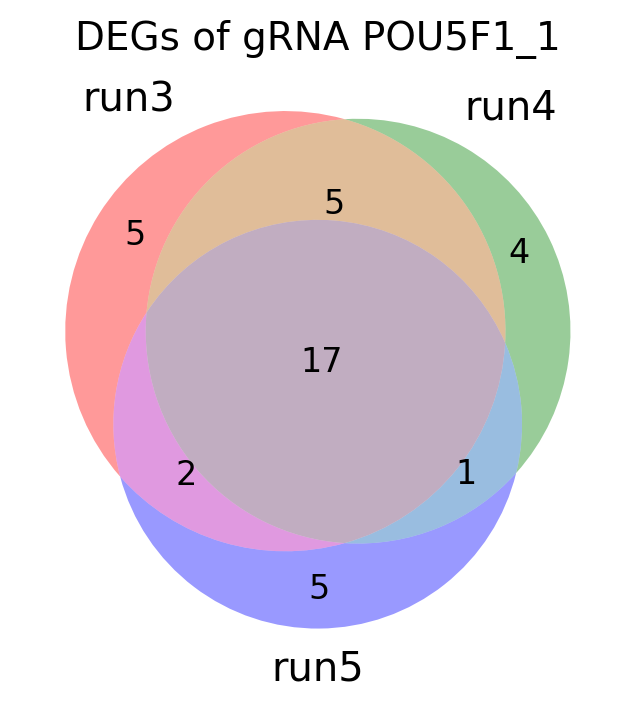

In [52]:
plot_venn3(degs3, degs4, degs5, "run3", "run4", "run5", title="DEGs of gRNA POU5F1_1")

Run DE with higher number of cells per rep

In [13]:
debug_res2 = differential_expression_multiple_runs(test_adata, min_cells_per_rep=20,
                                                  n_runs_per_target=5, debug=True)

Running in debug mode with 3 perturbations


Running DE analysis:   0%|          | 0/15 [00:00<?, ?it/s]

/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is es

In [16]:
test_df1 = debug_res["POU5F1_1-run1"]
test_df1[test_df1["padj"] < 0.05]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
DPP10,84.405180,4.084894,0.802063,5.092985,3.524694e-07,0.004939
PALLD,31.454393,5.440183,1.187741,4.580278,4.643576e-06,0.032535


In [17]:
test_df2 = debug_res["POU5F1_1-run2"]
test_df2[test_df2["padj"] < 0.05]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj


In [ ]:
test_df3 = debug_res["POU5F1_1-run3"]
test_df3[test_df3["padj"] < 0.05]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
CRABP2,13.290877,4.579100,1.193410,3.836986,1.245534e-04,8.797404e-03
MIR205HG,11.197178,3.714162,1.071801,3.465346,5.295491e-04,3.089804e-02
SOX11,13.892107,3.001957,0.862740,3.479562,5.022344e-04,3.063630e-02
LTBP1,17.410287,3.585396,0.875193,4.096693,4.190933e-05,4.017309e-03
DPP10,80.131645,3.915416,0.483312,8.101214,5.441353e-16,7.302295e-13
EPHA4,14.612873,4.792277,1.212491,3.952424,7.736363e-05,6.107176e-03
ARL4C,16.148829,4.282145,1.023203,4.185041,2.851142e-05,2.943256e-03
RPL22L1,19.344911,-2.285759,0.663402,-3.445511,5.699806e-04,3.187141e-02
LINC01208,23.057779,6.441846,1.538717,4.186506,2.832819e-05,2.943256e-03
GRID2,117.601815,-1.552899,0.320676,-4.842588,1.281590e-06,2.714091e-04


In [22]:
print(f"{test_df3[test_df3['padj'] < 0.05].shape[0]} genes with padj < 0.05")
print(f"{test_df3[test_df3['pvalue'] < 0.05].shape[0]} genes with pval < 0.05")

29 genes with padj < 0.05
189 genes with pval < 0.05


In [19]:
test_df4 = debug_res["POU5F1_1-run4"]
test_df4[test_df4["padj"] < 0.05]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
CRABP2,13.558213,3.673994,0.994884,3.692887,2.217223e-04,1.313324e-02
SOX11,13.910844,2.813721,0.858197,3.278644,1.043072e-03,4.203321e-02
LTBP1,16.325508,3.628930,0.908997,3.992236,6.545307e-05,5.354420e-03
DPP10,77.855226,3.813752,0.435049,8.766249,1.847171e-18,1.987556e-15
ARL4C,15.540173,3.546173,0.911966,3.888493,1.008684e-04,6.783400e-03
LINC01208,23.756048,6.566737,1.535864,4.275599,1.906241e-05,1.864650e-03
ADGRL3,25.733006,2.074820,0.588072,3.528171,4.184417e-04,2.251216e-02
GRID2,111.709197,-1.415276,0.279884,-5.056644,4.266988e-07,9.182559e-05
PALLD,31.618757,4.112653,0.709107,5.799766,6.640767e-09,2.381822e-06
ADCY2,21.958400,-2.244271,0.640816,-3.502208,4.614197e-04,2.348616e-02


Run DE on gRNA with a large number of cells

In [55]:
gRNA_value_counts = adata[adata.obs.perturbed == "True"].obs.gRNA.value_counts()
gRNA_value_counts.head()

gRNA
HNF1A_1       279
BHLHE40_1     279
ARHGAP35_3    252
ZFP41_3       241
HNF4A_2       239
Name: count, dtype: int64

In [81]:
gRNA_value_counts[20]

190

In [66]:
gRNA_high = gRNA_value_counts.head().index.tolist()
print(gRNA_high)

['HNF1A_1', 'BHLHE40_1', 'ARHGAP35_3', 'ZFP41_3', 'HNF4A_2']


In [67]:
test_adata_high = adata[(adata.obs.perturbed == "False") | 
                        (adata.obs.gRNA.isin(gRNA_high))].copy()

In [68]:
high_de_res = differential_expression_multiple_runs(test_adata_high)

Running DE analysis:   0%|          | 0/25 [00:00<?, ?it/s]

In [69]:
high_de_res_dict = dict()
for gRNA in gRNA_high:
    high_de_res_dict[gRNA] = get_degs_across_runs(high_de_res, gRNA)

In [71]:
for gRNA in gRNA_high:
    degs_per_run = high_de_res_dict[gRNA][2]
    print(f"{gRNA} DEGs per run: {[len(degs_per_run[i]) for i in degs_per_run]}")

HNF1A_1 DEGs per run: [0, 0, 0, 0, 0]
BHLHE40_1 DEGs per run: [0, 0, 0, 0, 0]
ARHGAP35_3 DEGs per run: [2, 2, 2, 3, 2]
ZFP41_3 DEGs per run: [0, 0, 0, 0, 0]
HNF4A_2 DEGs per run: [0, 1, 0, 1, 1]


In [73]:
gRNA_high2 = gRNA_value_counts[5:10].index.tolist()
print(gRNA_high2)

['ZNF658_2', 'ZNF354A_1', 'VDR_2', 'ADNP2_1', 'ESR1_1']


In [74]:
test_adata_high2 = adata[(adata.obs.perturbed == "False") | 
                        (adata.obs.gRNA.isin(gRNA_high2))].copy()

In [75]:
high_de_res2 = differential_expression_multiple_runs(test_adata_high2)

Running DE analysis:   0%|          | 0/25 [00:00<?, ?it/s]

In [76]:
high_de_res_dict2 = dict()
for gRNA in gRNA_high2:
    high_de_res_dict2[gRNA] = get_degs_across_runs(high_de_res2, gRNA)
for gRNA in gRNA_high2:
    degs_per_run = high_de_res_dict2[gRNA][2]
    print(f"{gRNA} DEGs per run: {[len(degs_per_run[i]) for i in degs_per_run]}")

ZNF658_2 DEGs per run: [0, 0, 0, 0, 0]
ZNF354A_1 DEGs per run: [0, 0, 0, 0, 0]
VDR_2 DEGs per run: [0, 0, 0, 0, 0]
ADNP2_1 DEGs per run: [1, 1, 1, 1, 1]
ESR1_1 DEGs per run: [0, 0, 0, 0, 0]


In [77]:
gRNA_high3 = gRNA_value_counts[10:20].index.tolist()
print(gRNA_high3)

['ZFP37_2', 'ZSCAN18_3', 'ESR2_2', 'ZFP41_2', 'ESRRG_2', 'ZFP57_2', 'ESRRG_1', 'ZBTB22_2', 'ESR1_2', 'PHF1_3']


In [78]:
test_adata_high3 = adata[(adata.obs.perturbed == "False") | 
                        (adata.obs.gRNA.isin(gRNA_high3))].copy()

In [79]:
high_de_res3 = differential_expression_multiple_runs(test_adata_high3)

Running DE analysis:   0%|          | 0/50 [00:00<?, ?it/s]

/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)


In [80]:
high_de_res_dict3 = dict()
for gRNA in gRNA_high3:
    high_de_res_dict3[gRNA] = get_degs_across_runs(high_de_res3, gRNA)
for gRNA in gRNA_high3:
    degs_per_run = high_de_res_dict3[gRNA][2]
    print(f"{gRNA} DEGs per run: {[len(degs_per_run[i]) for i in degs_per_run]}")

ZFP37_2 DEGs per run: [0, 0, 0, 0, 0]
ZSCAN18_3 DEGs per run: [0, 1, 0, 0, 0]
ESR2_2 DEGs per run: [0, 0, 0, 0, 0]
ZFP41_2 DEGs per run: [0, 1, 0, 0, 0]
ESRRG_2 DEGs per run: [0, 0, 0, 0, 0]
ZFP57_2 DEGs per run: [0, 0, 0, 0, 0]
ESRRG_1 DEGs per run: [0, 0, 0, 0, 0]
ZBTB22_2 DEGs per run: [0, 0, 0, 0, 0]
ESR1_2 DEGs per run: [0, 0, 0, 0, 0]
PHF1_3 DEGs per run: [0, 0, 0, 0, 0]


In [ ]:
print(f"gRNA has {adata[adata.obs.gRNA == 'gRNA'].shape[0]} cells")

# Fall 2025 Week 6

Now using 5 DE runs per gRNA/gene target. This week, test overlapping pseudoreplicates.

In [2]:
import anndata as ad
import numpy as np
import pandas as pd
from scipy import sparse
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference
import gc

def generate_pseudoreplicates_for_DE(adata: ad.AnnData, 
                                     target_value: str, 
                                     ntc_cell_indices: pd.Index, 
                                     rng: np.random.Generator, 
                                     target_column: str = "perturbation", 
                                     min_cells_per_rep: int = 12,
                                     layer: str = "counts"):
    """
    Generate independent pseudoreplicates for a given target (gRNA or gene target) 
    and matched NTC cells. Manually set NTC as reference for DE analysis.
    """
    # Create views for target and NTC cells
    if target_column not in adata.obs:
        print(f"Error: {target_column} not in adata.obs")
        return
    target_mask = adata.obs[target_column] == target_value
    target_view = adata[target_mask]
    ntc_view = adata[ntc_cell_indices]

    # Get data matrices from counts layer
    if layer in adata.layers:
        target_data = target_view.layers[layer]
        ntc_data = ntc_view.layers[layer]
    else:
        target_data = target_view.X
        ntc_data = ntc_view.X        
    
    # Convert to dense if sparse
    if sparse.issparse(target_data):
        target_data = target_data.toarray()
    if sparse.issparse(ntc_data):
        ntc_data = ntc_data.toarray()

    # Calculate number of cells to sample
    n_target_cells = target_data.shape[0]
    n_ntc_cells = ntc_data.shape[0]
    if n_target_cells >= min_cells_per_rep * 2:
        n_reps = min(3, n_target_cells // min_cells_per_rep)
    else: # If too few cells for 2 reps x min_cells_per_rep cells
        n_reps = 2
    target_rep_size = n_target_cells // n_reps
    ntc_rep_size = min(target_rep_size, n_ntc_cells // n_reps)
    if ntc_rep_size < target_rep_size:
        print("Warning: Unmatched number of target and NTC cells")

    # Pre-allocate arrays for results
    target_bulk = np.zeros((n_reps, target_data.shape[1]), dtype=np.int64)
    ntc_bulk = np.zeros((n_reps, ntc_data.shape[1]), dtype=np.int64)

    # Sample cells for all replicates
    target_sample_size = target_rep_size * n_reps
    ntc_sample_size = ntc_rep_size * n_reps
    sampled_target_indices = \
        rng.choice(n_target_cells, target_sample_size, replace=False)
    sampled_ntc_indices = \
        rng.choice(n_ntc_cells, ntc_sample_size, replace=False)
    # Generate replicates using vectorized operations
    for i in range(n_reps):
        # Sample indices
        target_start, target_stop = i*target_rep_size, (i+1)*target_rep_size
        target_rep_indices = sampled_target_indices[target_start:target_stop]
        ntc_start, ntc_stop = i*ntc_rep_size, (i+1)*ntc_rep_size
        ntc_rep_indices = sampled_ntc_indices[ntc_start:ntc_stop]

        # Calculate sums using vectorized operations
        target_bulk[i] = np.sum(target_data[target_rep_indices], axis=0).astype(np.int64)
        ntc_bulk[i] = np.sum(ntc_data[ntc_rep_indices], axis=0).astype(np.int64)  

    # Create sample names
    if "_" in target_value:
        target_value = target_value.replace("_", "-")
    sample_names = [f"{target_value}-rep{i+1}" for i in range(n_reps)]
    control_names = [f"NTC-rep{i+1}" for i in range(n_reps)]
    
    # Combine data
    combined_data = np.vstack([target_bulk, ntc_bulk])
    combined_names = sample_names + control_names
    
    # Create metadata DF
    metadata_df = pd.DataFrame({
        'condition': [target_value] * n_reps + ['NTC'] * n_reps
    }, index=combined_names)
    # Set NTC as reference for DESeq2
    metadata_df["condition"] = pd.Categorical(
        metadata_df["condition"],
        categories=["NTC", target_value],
        ordered=True
        )
    
    # Create counts DF
    counts_df = pd.DataFrame(
        combined_data,
        index=combined_names,
        columns=adata.var_names
    )

    return counts_df, metadata_df

def differential_expression_multiple_runs(adata: ad.AnnData, 
                    target_column: str = "perturbation", 
                    ntc_cells_delimiter: str = "NTC", 
                    alpha: float = 0.05, n_cpus: int = 20, 
                    min_cells_per_rep: int = 12,
                    n_runs_per_target: int = 5,
                    layer: str = "counts", random_state: int = 42, 
                    shrink_lfcs: bool = False, debug: bool = False):
    """
    Run differential expression analysis on each perturbation in the 
    dataset n_runs_per_target times per perturbation. Return dict of 
    {perturbation_run : DE results for that perturbation and run}.
    """
    # Identify KD and NTC cells
    perturbations = list(adata.obs[target_column].unique())
    perturbations.remove(ntc_cells_delimiter) # Remove NTC group
    if debug == True: # Debug mode: run with 3 perturbations
        print(f"Running in debug mode with 3 perturbations")
        perturbations = perturbations[:3]
    ntc_cell_indices = np.where(adata.obs[target_column] == ntc_cells_delimiter)[0]

    # Create multiple runs per perturbation
    if n_runs_per_target > 0:
        perturbations_runs = [f"{pert}-run{i+1}" for pert in perturbations
                                for i in range(n_runs_per_target)]
    else:
        perturbations_runs = perturbations

    # Create RNG object
    de_rng = np.random.default_rng(random_state)
    # Create one child RNG object per perturbation and run
    streams = de_rng.spawn(len(perturbations_runs))

    # Determine how many CPUs to use per joblib Parallel job
    #   and per DE analysis run
    if n_cpus < 3:
        n_cpus_for_DE = n_cpus
    elif n_cpus <= 10:
        n_cpus_for_DE = 3
    elif 20 <= n_cpus < 30:
        n_cpus_for_DE = 4
    elif 30 <= n_cpus < 50:
        n_cpus_for_DE = 5
    else:
        n_cpus_for_DE = 6
    n_jobs = max(1, n_cpus // n_cpus_for_DE)

    # Warning if given layer not found
    if layer not in adata.layers:
         print(f"Warning: {layer} not in adata.layers, using adata.X instead")

    # Function to run DE analysis on a single perturbation
    quiet = True
    def process_perturbation(target_value: str, rng: np.random.Generator, quiet=quiet):
        # Get actual target value
        if "-run" in target_value:
            target_value = target_value.split("-run")[0]
        
        # Generate pseudoreplicates
        pseudo_bulk_df, metadata_df = generate_pseudoreplicates_for_DE(
            adata, target_value, ntc_cell_indices, rng, 
            target_column=target_column, min_cells_per_rep=min_cells_per_rep,
            layer=layer
        )

        # Set number of CPUs to use for each DE run
        inference = DefaultInference(n_cpus=n_cpus_for_DE) 

        # Read counts modeling and fitting dispersions
        dds = DeseqDataSet(
            counts = pseudo_bulk_df, 
            metadata = metadata_df,
            refit_cooks=True,
            inference=inference,
            quiet=quiet
            )
        dds.deseq2()
        
        # Statistical testing
        target_hyphenated = target_value.replace('_', '-')
        contrast = ["condition", target_hyphenated, ntc_cells_delimiter]
        stat_res = DeseqStats(
            dds, 
            contrast=contrast, 
            alpha=alpha,
            inference=inference,
            quiet=quiet)
        stat_res.summary()
        if shrink_lfcs == True:
            # Shrink LFCs for downstream analysis
            stat_res.lfc_shrink(coeff=f"condition_{contrast[1]}_vs_{contrast[2]}", 
                                adapt=False)
        results_df = stat_res.results_df

        # Clean up memory
        del pseudo_bulk_df, metadata_df, dds, stat_res
        gc.collect()

        # Return results with and without LFC shrinkage
        return results_df

    # Run DE analysis on all perturbations in parallel
    with tqdm_joblib(desc="Running DE analysis", total=len(perturbations_runs)):
        results = Parallel(n_jobs=n_jobs)(delayed(process_perturbation)(target_value, rng)
            for target_value, rng in zip(perturbations_runs, streams))
    
    results_dict = dict(zip(perturbations_runs, results))
    return results_dict

## DE analysis - combining p-values

In [3]:
filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_KD_ETest_Gene_Filtered.h5ad"
adata = psp.utils.read_anndata(filepath)
adata

AnnData object with n_obs × n_vars = 101923 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

Generate small test dataset

In [4]:
# 30 KDs with highest number of DEGs, from updated pipeline example notebook
top_30_kds_by_n_degs = \
    {'MYADM', 'DBR1', 'POU5F1', 'PTPN1', 'POU5F1B', 'JOSD1', 'ST13', 'HRC', 'TOMM40', 'KAT2A', 
     'PHF20', 'PSMD8', 'NAE1', 'POU3F2', 'HCCS', 'DDX6', 'SMARCC1', 'DNMT1', 'TMX2', 'SMARCE1', 
     'TADA2B', 'VHL', 'TAF4', 'EMSY', 'ZNF521', 'RBM14', 'NANOG', 'IDI1', 'RNF7', 'ZNF396'}

# KDs to test
test_kds = top_30_kds_by_n_degs & set(adata.obs.gene_target.unique().tolist())
print(f"{len(test_kds)} KDs to test: {', '.join(test_kds)}")

# gRNA to test
gRNA_to_test = adata[adata.obs.gene_target.isin(test_kds)].obs.gRNA.unique().tolist()
print(f"{len(gRNA_to_test)} gRNA to test")

8 KDs to test: ZNF521, DNMT1, POU5F1, POU3F2, NANOG, PHF20, ZNF396, POU5F1B
14 gRNA to test


In [5]:
test_adata = adata[(adata.obs.perturbed == "False") |
                   (adata.obs.gene_target.isin(test_kds))].copy()
test_adata

AnnData object with n_obs × n_vars = 14437 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

Run DE on test_adata with 5 DE runs per gRNA and minimum 20 cells per pseudoreplicate

In [6]:
test_DE_res = differential_expression_multiple_runs(
    test_adata, min_cells_per_rep=20, n_runs_per_target=5, n_cpus=30)

Running DE analysis:   0%|          | 0/70 [00:00<?, ?it/s]

/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is es

In [122]:
def build_DE_test_results_df(de_results_dict: dict, adata: ad.AnnData, 
                             target_column: str = "gRNA",
                             alpha: float=0.05, padj_col: str = "padj",
                             run_delimiter: str = "-run"):
    """
    Build DataFrame of each gRNA, number of cells, and DEGs per run.
    """
    target_list = sorted(list({target.split(run_delimiter)[0] 
                               for target in de_results_dict}))
    n_runs = len({target.split(run_delimiter)[1] for target in de_results_dict})
    n_cells_list = [adata[adata.obs[target_column] == target].shape[0] 
                    for target in target_list]
    n_degs_dict = {f"Run{i} DEGs": list() for i in range(1, n_runs+1)}

    for target in target_list:
        for i in range(1, n_runs+1):
            de_run_df = de_results_dict[f"{target}-run{i}"]
            degs = set(de_run_df[de_run_df[padj_col] < alpha].index.tolist())
            n_degs_dict[f"Run{i} DEGs"].append(len(degs))
    results_dict = {target_column: target_list, "# cells": n_cells_list} | n_degs_dict
    results_df = pd.DataFrame.from_dict(results_dict)
    degs_df = results_df.iloc[:,2:]
    median_degs = degs_df.median(axis=1).astype(int)
    mean_degs = degs_df.mean(axis=1)
    results_df["Median DEGs"] = median_degs
    results_df["Mean DEGs"] = mean_degs.round(1)
    results_df = results_df.set_index("gRNA")
    return results_df

In [123]:
test_n_degs_df = build_DE_test_results_df(test_DE_res, test_adata)

In [124]:
display(test_n_degs_df.sort_values(by="# cells"))

,# cells,Run1 DEGs,Run2 DEGs,Run3 DEGs,Run4 DEGs,Run5 DEGs,Median DEGs,Mean DEGs
gRNA,,,,,,,,
POU5F1_1,27,2,0,29,27,25,25,16.6
POU5F1_2,29,0,26,48,55,48,48,35.4
NANOG_1,38,1,2,2,1,0,1,1.2
POU5F1B_1,44,80,74,84,74,71,74,76.6
DNMT1_2,45,2,2,6,3,5,3,3.6
PHF20_1,46,61,55,53,51,58,55,55.6
POU3F2_2,50,29,36,34,50,32,34,36.2
DNMT1_1,50,3,0,0,3,2,2,1.6
POU5F1_3,50,50,54,64,70,57,57,59.0


We will use the gRNA POU5F1_3 (with 50 cells and 50-70 DEGs per run) and ZNF521_1 (with 83 cells and 11-56 DEGs per run) to test the p-value combination methods.

In [127]:
pou5f1_3_run1_df = test_DE_res["POU5F1_3-run1"]
pou5f1_3_run1_df.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000241860,0.000000,NaN,NaN,NaN,NaN,NaN
ENSG00000290385,0.949386,1.476598,2.765626,0.533911,0.593403,NaN
ENSG00000291215,0.968810,-1.685225,2.758093,-0.611011,0.541192,NaN
LINC01409,0.250000,-1.512336,5.344476,-0.282972,0.777199,NaN
LINC00115,0.000000,NaN,NaN,NaN,NaN,NaN


In [ ]:
def build_multi_run_dfs(target: str, de_results_dict: dict,
                                pvalue_col: str = "pvalue",
                                lfc_col: str = "log2FoldChange",
                                test_stat_col: str = "stat",
                                run_delimiter: str = "-run"):
    """
    Given a perturbation and DE results for that perturbation across
    multiple runs, build 3 DFs of: 1) p-value, 2) median LFC, 
    number of runs with a negative LFC, and number of runs with a 
    positive LFC; 3) Wald test statistic
    """
    target_runs = [run for run in de_results_dict if target in run]
    n_runs = len(target_runs)
    genes = de_results_dict[target_runs[0]].index
    pvals_dict, stat_dict = dict(), dict()
    lfc_array = np.zeros((len(genes), n_runs))

    # Check that all run DFs have same index; if not, sort later
    sort_genes = False
    for run in target_runs[1:]:
        if not de_results_dict[run].index.equals(genes):
            sort_genes = True
            print("DE run results do not all have same index")
    
    # Get p-values and LFCs from each run
    for i in range(n_runs):
        run_df = de_results_dict[target + run_delimiter + str(i+1)]
        if sort_genes:
            run_df = run_df.sort_index()
        lfc_array[:, i] = run_df[lfc_col].values
        pvals_dict[f"Run{i+1} pval"] = run_df[pvalue_col]
        stat_dict[f"Run{i+1} stat"] = run_df[test_stat_col]

    # Process LFCs
    median_lfcs = np.nanmedian(lfc_array, axis=1)
    n_pos_lfcs = (lfc_array > 0).sum(axis=1)
    n_neg_lfcs = (lfc_array < 0).sum(axis=1)
    lfc_dict = {"Median LFC": median_lfcs, 
                "# positive LFCs": n_pos_lfcs,
                "# negative LFCs": n_neg_lfcs}

    pval_df = pd.DataFrame.from_dict({"Gene": genes} | pvals_dict)
    pval_df.set_index("Gene", inplace=True)
    pval_df.index.rename("", inplace=True)
    lfc_df = pd.DataFrame.from_dict({"Gene": genes} | lfc_dict)
    lfc_df.set_index("Gene", inplace=True)
    lfc_df.index.rename("", inplace=True)
    stat_df = pd.DataFrame.from_dict({"Gene": genes} | stat_dict)
    stat_df.set_index("Gene", inplace=True)
    stat_df.index.rename("", inplace=True)
    return pval_df, lfc_df, stat_df

In [157]:
test_POU5F1_3_pval_df, test_POU5F1_3_lfc_df, test_POU5F1_3_stat_df = \
    build_multi_run_dfs("POU5F1_3", test_DE_res)

/tmp/ipykernel_1597992/3329123028.py:35: RuntimeWarning: All-NaN slice encountered


In [144]:
test_POU5F1_3_pval_df.head()

,Run1 pval,Run2 pval,Run3 pval,Run4 pval,Run5 pval
,,,,,
ENSG00000241860,NaN,0.784011,0.384298,NaN,0.424135
ENSG00000290385,0.593403,0.859404,0.587679,0.406486,0.584446
ENSG00000291215,0.541192,0.776014,0.980315,0.527221,0.724898
LINC01409,0.777199,0.308307,0.766198,NaN,NaN
LINC00115,NaN,NaN,NaN,NaN,NaN


In [185]:
small_test_POU5F1_3_pval_df = test_POU5F1_3_pval_df.sort_values(by="Run1 pval").head()
small_test_POU5F1_3_pval_df = small_test_POU5F1_3_pval_df.sort_index()
small_test_POU5F1_3_pval_df

,Run1 pval,Run2 pval,Run3 pval,Run4 pval,Run5 pval
,,,,,
DPP10,1.201163e-36,1.903675e-13,1.898331e-35,3.389900e-38,1.140537e-34
GRID2,6.167470e-13,2.370232e-09,8.916936e-07,6.431171e-08,9.904301e-13
LRRC4C,1.069916e-13,1.208603e-10,4.083109e-12,7.678643e-13,3.825185e-10
MALAT1,1.195492e-23,1.985840e-06,2.674618e-19,1.390739e-17,8.315330e-17
PALLD,1.114617e-12,6.893450e-12,3.548127e-12,1.276954e-12,2.136295e-13


In [186]:
small_test_POU5F1_3_stat_df = \
test_POU5F1_3_stat_df[test_POU5F1_3_stat_df.index.isin(small_test_POU5F1_3_pval_df.index.tolist())]
small_test_POU5F1_3_stat_df.sort_index()
small_test_POU5F1_3_stat_df

,Run1 stat,Run2 stat,Run3 stat,Run4 stat,Run5 stat
,,,,,
DPP10,12.644414,7.355392,12.425585,12.921828,12.281368
GRID2,-7.196728,-5.970158,-4.914148,-5.406379,-7.131830
PALLD,7.115557,6.859847,6.954103,7.096782,7.339978
LRRC4C,7.431971,6.438248,6.934275,7.166773,6.260999
MALAT1,10.024012,4.754860,8.981351,8.535896,8.326663


In [145]:
test_POU5F1_3_lfc_df.head()

,Median LFC,# positive LFCs,# negative LFCs
,,,
ENSG00000241860,-3.020088,0,3
ENSG00000290385,1.476598,5,0
ENSG00000291215,-1.031940,0,5
LINC01409,-1.586175,0,3
LINC00115,NaN,0,0


In [158]:
test_POU5F1_3_stat_df.head()

,Run1 stat,Run2 stat,Run3 stat,Run4 stat,Run5 stat
,,,,,
ENSG00000241860,NaN,-0.274096,-0.870004,NaN,-0.799269
ENSG00000290385,0.533911,0.177133,0.542203,0.830094,0.546902
ENSG00000291215,-0.611011,-0.284517,-0.024674,-0.632254,-0.351921
LINC01409,-0.282972,-1.018781,-0.297352,NaN,NaN
LINC00115,NaN,NaN,NaN,NaN,NaN


Combine p-values

In [204]:
from scipy.stats import combine_pvalues, false_discovery_control
metacp_root = "/home/ranwyl/metacp/"
if metacp_root not in sys.path:
    sys.path.insert(0, metacp_root)
import metacp
import warnings

def combine_pvalues_single_target(pval_df: pd.DataFrame, pval_method: str,
                                  stat_df = None,
                                  nan_policy: str = "propagate", 
                                  fdr_method: str = "bh"):
    pval_df = pval_df.copy()
    # Combine p-values
    combined_pvals = list()
    if pval_method == "fisher" or pval_method == "stouffer":
        for i in range(len(pval_df)):
            gene_pvals = pval_df.iloc[i].values
            combined_pvals.append(
                combine_pvalues(gene_pvals, method=pval_method, 
                                nan_policy=nan_policy).pvalue)
    elif pval_method == "cauchy": # Cauchy Combination Test
        for i in range(len(pval_df)):
            gene_pvals = pval_df.iloc[i].values
            combined_pvals.append(
                metacp.cauchy_method(gene_pvals, data_type="pvals"))
    # elif pval_method == "ebm": # Empirical Brown's method
    #     if stat_df is None:
    #         print(f"Error: Need test statistic DataFrame for EBM")
    #         return
    #     stat_df_clean = stat_df.dropna(axis=0)
    #     for i in range(len(pval_df)):
    #         gene_pvals = pval_df.iloc[i].values
    #         if np.any(np.isnan(gene_pvals)):
    #             combined_pvals.append(np.nan)
    #         else:
    #             combined_pvals.append(
    #                 metacp.EmpiricalBrownsMethod(
    #                     gene_pvals, stat_df_clean.values, data_type="pvals"))
    elif pval_method == "hmp": # Harmonic Mean P-value
        for i in range(len(pval_df)):
            gene_pvals = pval_df.iloc[i].values
            combined_pvals.append(
                 len(gene_pvals) / np.sum(1 / gene_pvals)
            )
    pval_col = f"Combined pval ({pval_method})"
    pval_df[pval_col] = combined_pvals
    
    # FDR
    nan_mask = pval_df[pval_col].notna()
    fdrs = false_discovery_control(pval_df.loc[nan_mask, pval_col], 
                                   method=fdr_method)
    fdr_col = f"FDR ({pval_method}, {fdr_method})"
    pval_df[fdr_col] = np.nan
    pval_df.loc[nan_mask, fdr_col] = fdrs
    return pval_df

def get_n_degs(pval_df: pd.DataFrame, fdr_col: str, alpha: float = 0.05):
    return(pval_df[pval_df[fdr_col] < alpha].shape[0])

def test_pval_combination_methods(target: str, 
                                  de_results_dict: dict,
                                  n_degs_df: pd.DataFrame,
                                  alpha: float=0.05,
                                  target_delimiter: str="gRNA",
                                  pvalue_col: str = "pvalue",
                                  lfc_col: str = "log2FoldChange",
                                  test_stat_col: str = "stat",
                                  run_delimiter: str = "-run",
                                  catch_warnings: bool=True):
    if catch_warnings:
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            pval_df, lfc_df, stat_df = \
                build_multi_run_dfs(target, de_results_dict,
                                    pvalue_col=pvalue_col, lfc_col=lfc_col,
                                    test_stat_col=test_stat_col,
                                    run_delimiter=run_delimiter)
    else:
        pval_df, lfc_df, stat_df = \
            build_multi_run_dfs(target, de_results_dict,
                                pvalue_col=pvalue_col, lfc_col=lfc_col,
                                test_stat_col=test_stat_col,
                                run_delimiter=run_delimiter)
    
    fisher_df = combine_pvalues_single_target(pval_df, pval_method="fisher")
    stouffer_df = combine_pvalues_single_target(pval_df, pval_method="stouffer")
    cauchy_df = combine_pvalues_single_target(pval_df, pval_method="cauchy")
    hmp_df = combine_pvalues_single_target(pval_df, pval_method="hmp")
    print(f"{target_delimiter}: {target} ({n_degs_df.loc[target, '# cells']} cells)")
    print(f"Median # DEGs over all runs: {n_degs_df.loc[target, 'Median DEGs']}")
    print(f"Mean # DEGs over all runs: {n_degs_df.loc[target, 'Mean DEGs']}")
    print(f"Fisher's method # DEGs: " 
          f"{get_n_degs(fisher_df, 'FDR (fisher, bh)', alpha=alpha)}")
    print(f"Stouffer's method # DEGs: "
          f"{get_n_degs(stouffer_df, 'FDR (stouffer, bh)', alpha=alpha)}")
    print(f"Cauchy Combination Test # DEGs: "
          f"{get_n_degs(cauchy_df, 'FDR (cauchy, bh)', alpha=alpha)}")
    print(f"Harmonic Mean p-value # DEGs: "
          f"{get_n_degs(hmp_df, 'FDR (hmp, bh)', alpha=alpha)}")

In [148]:
test_POU5F1_3_fisher_pval_df = \
    combine_pvalues_single_target(test_POU5F1_3_pval_df, pval_method="fisher")
with pd.option_context('display.precision', 3):
    display(test_POU5F1_3_fisher_pval_df.sort_values(by="FDR (fisher, bh)"))

,Run1 pval,Run2 pval,Run3 pval,Run4 pval,Run5 pval,Combined pval (fisher),"FDR (fisher, bh)"
,,,,,,,
DPP10,1.201e-36,1.904e-13,1.898e-35,3.390e-38,1.141e-34,1.141e-146,1.624e-142
MALAT1,1.195e-23,1.986e-06,2.675e-19,1.391e-17,8.315e-17,3.625e-73,2.581e-69
PCDH11Y,2.307e-12,2.765e-11,4.576e-14,1.982e-12,4.315e-13,3.801e-53,1.804e-49
PALLD,1.115e-12,6.893e-12,3.548e-12,1.277e-12,2.136e-13,1.097e-52,3.904e-49
LRRC4C,1.070e-13,1.209e-10,4.083e-12,7.679e-13,3.825e-10,1.818e-49,5.178e-46
...,...,...,...,...,...,...,...
HAUS7,NaN,7.840e-01,2.164e-01,5.459e-01,7.775e-01,NaN,NaN
RENBP,NaN,NaN,7.768e-01,7.754e-01,NaN,NaN,NaN
TMEM187,5.405e-01,7.688e-01,NaN,7.754e-01,7.846e-01,NaN,NaN


In [149]:
test_POU5F1_3_stouffer_pval_df = \
    combine_pvalues_single_target(test_POU5F1_3_pval_df, pval_method="stouffer")
with pd.option_context('display.precision', 3):
    display(test_POU5F1_3_stouffer_pval_df.sort_values(by="FDR (stouffer, bh)"))

,Run1 pval,Run2 pval,Run3 pval,Run4 pval,Run5 pval,Combined pval (stouffer),"FDR (stouffer, bh)"
,,,,,,,
DPP10,1.201e-36,1.904e-13,1.898e-35,3.390e-38,1.141e-34,3.327e-145,4.738e-141
MALAT1,1.195e-23,1.986e-06,2.675e-19,1.391e-17,8.315e-17,1.809e-72,1.288e-68
PCDH11Y,2.307e-12,2.765e-11,4.576e-14,1.982e-12,4.315e-13,1.441e-55,6.841e-52
PALLD,1.115e-12,6.893e-12,3.548e-12,1.277e-12,2.136e-13,3.654e-55,1.301e-51
FBN2,6.057e-12,4.117e-11,1.371e-11,4.432e-12,1.472e-12,9.624e-52,2.417e-48
...,...,...,...,...,...,...,...
HAUS7,NaN,7.840e-01,2.164e-01,5.459e-01,7.775e-01,NaN,NaN
RENBP,NaN,NaN,7.768e-01,7.754e-01,NaN,NaN,NaN
TMEM187,5.405e-01,7.688e-01,NaN,7.754e-01,7.846e-01,NaN,NaN


In [150]:
test_POU5F1_3_cauchy_pval_df = \
    combine_pvalues_single_target(test_POU5F1_3_pval_df, pval_method="cauchy", fdr_method="bh")
with pd.option_context('display.precision', 3):
    display(test_POU5F1_3_cauchy_pval_df.sort_values(by="FDR (cauchy, bh)"))

,Run1 pval,Run2 pval,Run3 pval,Run4 pval,Run5 pval,Combined pval (cauchy),"FDR (cauchy, bh)"
,,,,,,,
MALAT1,1.195e-23,1.986e-06,2.675e-19,1.391e-17,8.315e-17,1.332e-15,9.485e-12
DPP10,1.201e-36,1.904e-13,1.898e-35,3.390e-38,1.141e-34,1.332e-15,9.485e-12
PCDH11Y,2.307e-12,2.765e-11,4.576e-14,1.982e-12,4.315e-13,1.988e-13,9.438e-10
LRRC4C,1.070e-13,1.209e-10,4.083e-12,7.679e-13,3.825e-10,4.584e-13,1.632e-09
PALLD,1.115e-12,6.893e-12,3.548e-12,1.277e-12,2.136e-13,7.365e-13,2.097e-09
...,...,...,...,...,...,...,...
HAUS7,NaN,7.840e-01,2.164e-01,5.459e-01,7.775e-01,NaN,NaN
RENBP,NaN,NaN,7.768e-01,7.754e-01,NaN,NaN,NaN
TMEM187,5.405e-01,7.688e-01,NaN,7.754e-01,7.846e-01,NaN,NaN


In [ ]:
test_POU5F1_3_ebm_pval_df = \
    combine_pvalues_single_target(test_POU5F1_3_pval_df, 
                                  pval_method="ebm", 
                                  stat_df=test_POU5F1_3_stat_df)
with pd.option_context('display.precision', 3):
    display(test_POU5F1_3_ebm_pval_df.sort_values(by="FDR (ebm, bh)"))

In [210]:
small_test_POU5F1_3_cauchy_pval_df = \
    combine_pvalues_single_target(small_test_POU5F1_3_pval_df, 
                                  pval_method="cauchy")
with pd.option_context('display.precision', 3):
    display(small_test_POU5F1_3_cauchy_pval_df.sort_values(by="FDR (cauchy, bh)"))

,Run1 pval,Run2 pval,Run3 pval,Run4 pval,Run5 pval,Combined pval (cauchy),"FDR (cauchy, bh)"
,,,,,,,
DPP10,1.201e-36,1.904e-13,1.898e-35,3.390e-38,1.141e-34,1.332e-15,3.331e-15
MALAT1,1.195e-23,1.986e-06,2.675e-19,1.391e-17,8.315e-17,1.332e-15,3.331e-15
LRRC4C,1.070e-13,1.209e-10,4.083e-12,7.679e-13,3.825e-10,4.584e-13,7.640e-13
PALLD,1.115e-12,6.893e-12,3.548e-12,1.277e-12,2.136e-13,7.365e-13,9.207e-13
GRID2,6.167e-13,2.370e-09,8.917e-07,6.431e-08,9.904e-13,1.900e-12,1.900e-12


In [209]:
small_test_POU5F1_3_hmp_pval_df = \
    combine_pvalues_single_target(small_test_POU5F1_3_pval_df, 
                                  pval_method="hmp")
with pd.option_context('display.precision', 3):
    display(small_test_POU5F1_3_hmp_pval_df.sort_values(by="FDR (hmp, bh)"))

,Run1 pval,Run2 pval,Run3 pval,Run4 pval,Run5 pval,Combined pval (hmp),"FDR (hmp, bh)"
,,,,,,,
DPP10,1.201e-36,1.904e-13,1.898e-35,3.390e-38,1.141e-34,1.645e-37,8.225e-37
MALAT1,1.195e-23,1.986e-06,2.675e-19,1.391e-17,8.315e-17,5.977e-23,1.494e-22
LRRC4C,1.070e-13,1.209e-10,4.083e-12,7.679e-13,3.825e-10,4.585e-13,7.642e-13
PALLD,1.115e-12,6.893e-12,3.548e-12,1.277e-12,2.136e-13,7.366e-13,9.207e-13
GRID2,6.167e-13,2.370e-09,8.917e-07,6.431e-08,9.904e-13,1.900e-12,1.900e-12


In [205]:
test_pval_combination_methods("POU5F1_3", test_DE_res, test_n_degs_df)

gRNA: POU5F1_3 (50 cells)
Median # DEGs over all runs: 57
Mean # DEGs over all runs: 59.0
Fisher's method # DEGs: 278
Stouffer's method # DEGs: 368
Cauchy Combination Test # DEGs: 48
Harmonic Mean p-value # DEGs: 48


In [206]:
test_pval_combination_methods("ZNF521_1", test_DE_res, test_n_degs_df)

gRNA: ZNF521_1 (83 cells)
Median # DEGs over all runs: 49
Mean # DEGs over all runs: 42.6
Fisher's method # DEGs: 235
Stouffer's method # DEGs: 343
Cauchy Combination Test # DEGs: 44
Harmonic Mean p-value # DEGs: 44


In [207]:
test_pval_combination_methods("POU5F1B_1", test_DE_res, test_n_degs_df)

gRNA: POU5F1B_1 (44 cells)
Median # DEGs over all runs: 74
Mean # DEGs over all runs: 76.6
Fisher's method # DEGs: 311
Stouffer's method # DEGs: 426
Cauchy Combination Test # DEGs: 60
Harmonic Mean p-value # DEGs: 60


In [208]:
test_pval_combination_methods("POU5F1_1", test_DE_res, test_n_degs_df)

gRNA: POU5F1_1 (27 cells)
Median # DEGs over all runs: 25
Mean # DEGs over all runs: 16.6
Fisher's method # DEGs: 100
Stouffer's method # DEGs: 155
Cauchy Combination Test # DEGs: 16
Harmonic Mean p-value # DEGs: 16
